In [1]:
#!pip install cv2
import os
import sys
import cv2
import time
import pickle
import numpy as np 
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import time
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## generators to send image data to the sequential (cnn) model
#classes = ['A', 'C', 'M', 'N', 'S', 'T', 'V']
#classes = ['A', 'N', 'S', 'V']
classes = ['C', 'FA', 'M', 'S']


img_height,img_width = 128,128

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('250ms/training_set',
                                                    target_size=(img_height,img_width),
                                                    batch_size=20,
                                                    shuffle=False,
                                                    classes=classes,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('250ms/testing_set',
                                                  target_size=(img_height,img_width),
                                                  batch_size=20,
                                                  shuffle=False,
                                                  classes=classes,
                                                  class_mode='categorical')

hold_datagen = ImageDataGenerator(rescale=1./255)
hold_generator = hold_datagen.flow_from_directory('250ms/hold_out',
                                                  target_size=(img_height,img_width),
                                                  batch_size=20,
                                                  shuffle=False,
                                                  classes=classes,
                                                  class_mode='categorical')



Found 69116 images belonging to 4 classes.
Found 23040 images belonging to 4 classes.
Found 23040 images belonging to 4 classes.


In [3]:
num_category = 4

## model building
model = Sequential()

## please modify the model as per your requirements
model.add(Conv2D(16, kernel_size=(3, 7), activation='relu',
                 input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(3, 7)))
model.add(Dropout(rate=0.1))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(20, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(120, 3, activation='relu'))
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(num_category, activation='softmax'))


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
monitor = [ EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=5,
                            verbose=0,
                            mode='auto'),ModelCheckpoint(filepath="spec_500ms_mani_weights.h5",
                                   verbose=0,
                                   save_best_only=True)] # save best model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 122, 16)      1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 17, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 15, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 13, 20)        5780      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 4, 20)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 4, 20)         0         
__________

### Training model

In [5]:
## no of steps per epoch (total no. of images / batch size of imagedatagenerator)
train_steps = train_generator.n//train_generator.batch_size+1
test_steps = test_generator.n//test_generator.batch_size+1

train_generator.reset()
test_generator.reset()

tic=time.time()
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              epochs=25,callbacks= monitor,
                              validation_data=test_generator,
                              validation_steps=test_steps,
                              verbose=1)     
toc=time.time()
print(str(1000*(toc-tic))+"ms")

Epoch 1/25
  18/3456 [..............................] - ETA: 24:30 - loss: 1.4701 - acc: 0.3944 ETA: 31:19 - loss: 1.4993

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101400). Check your callbacks.
  % delta_t_median)


  20/3456 [..............................] - ETA: 24:18 - loss: 1.4740 - acc: 0.37 - ETA: 23:49 - loss: 1.4772 - acc: 0.3550

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124800). Check your callbacks.
  % delta_t_median)


  22/3456 [..............................] - ETA: 23:39 - loss: 1.4636 - acc: 0.3705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148200). Check your callbacks.
  % delta_t_median)


  26/3456 [..............................] - ETA: 23:25 - loss: 1.4589 - acc: 0.3135

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156000). Check your callbacks.
  % delta_t_median)


  27/3456 [..............................] - ETA: 23:30 - loss: 1.4589 - acc: 0.3019

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148401). Check your callbacks.
  % delta_t_median)


  28/3456 [..............................] - ETA: 23:35 - loss: 1.4544 - acc: 0.3268

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152200). Check your callbacks.
  % delta_t_median)


  31/3456 [..............................] - ETA: 23:43 - loss: 1.4490 - acc: 0.2968

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144601). Check your callbacks.
  % delta_t_median)


  32/3456 [..............................] - ETA: 23:40 - loss: 1.4482 - acc: 0.2875

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103801). Check your callbacks.
  % delta_t_median)


  33/3456 [..............................] - ETA: 23:38 - loss: 1.4461 - acc: 0.2833

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140601). Check your callbacks.
  % delta_t_median)


  35/3456 [..............................] - ETA: 23:54 - loss: 1.4426 - acc: 0.2686

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103601). Check your callbacks.
  % delta_t_median)


  39/3456 [..............................] - ETA: 24:01 - loss: 1.4363 - acc: 0.2795

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109200). Check your callbacks.
  % delta_t_median)


  43/3456 [..............................] - ETA: 23:57 - loss: 1.4310 - acc: 0.2953

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126701). Check your callbacks.
  % delta_t_median)


  53/3456 [..............................] - ETA: 24:41 - loss: 1.4183 - acc: 0.3368

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125001). Check your callbacks.
  % delta_t_median)


  54/3456 [..............................] - ETA: 24:37 - loss: 1.4192 - acc: 0.3306

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164300). Check your callbacks.
  % delta_t_median)


  57/3456 [..............................] - ETA: 24:29 - loss: 1.4135 - acc: 0.3386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171600). Check your callbacks.
  % delta_t_median)


  64/3456 [..............................] - ETA: 24:09 - loss: 1.4093 - acc: 0.3211

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140400). Check your callbacks.
  % delta_t_median)


  67/3456 [..............................] - ETA: 24:03 - loss: 1.4015 - acc: 0.3448

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117000). Check your callbacks.
  % delta_t_median)


  78/3456 [..............................] - ETA: 23:42 - loss: 1.3999 - acc: 0.3365

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118000). Check your callbacks.
  % delta_t_median)


  80/3456 [..............................] - ETA: 23:30 - loss: 1.3960 - acc: 0.3462

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163800). Check your callbacks.
  % delta_t_median)


  84/3456 [..............................] - ETA: 23:25 - loss: 1.3796 - acc: 0.3518

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120802). Check your callbacks.
  % delta_t_median)


  91/3456 [..............................] - ETA: 23:17 - loss: 1.3483 - acc: 0.3747

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118901). Check your callbacks.
  % delta_t_median)


  93/3456 [..............................] - ETA: 23:13 - loss: 1.3376 - acc: 0.3785

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100501). Check your callbacks.
  % delta_t_median)


 103/3456 [..............................] - ETA: 23:01 - loss: 1.3155 - acc: 0.3966

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132001). Check your callbacks.
  % delta_t_median)


 104/3456 [..............................] - ETA: 23:03 - loss: 1.3071 - acc: 0.4024

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139801). Check your callbacks.
  % delta_t_median)


 105/3456 [..............................] - ETA: 23:03 - loss: 1.2970 - acc: 0.4081

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142301). Check your callbacks.
  % delta_t_median)


 106/3456 [..............................] - ETA: 23:03 - loss: 1.2972 - acc: 0.4057

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150101). Check your callbacks.
  % delta_t_median)


 109/3456 [..............................] - ETA: 23:03 - loss: 1.3123 - acc: 0.3950

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157901). Check your callbacks.
  % delta_t_median)


 110/3456 [..............................] - ETA: 23:00 - loss: 1.3022 - acc: 0.4005

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172202). Check your callbacks.
  % delta_t_median)


 112/3456 [..............................] - ETA: 23:01 - loss: 1.3014 - acc: 0.3946

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185901). Check your callbacks.
  % delta_t_median)


 118/3456 [>.............................] - ETA: 23:06 - loss: 1.2958 - acc: 0.3894

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170301). Check your callbacks.
  % delta_t_median)


 120/3456 [>.............................] - ETA: 23:05 - loss: 1.2946 - acc: 0.3925

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106400). Check your callbacks.
  % delta_t_median)


 133/3456 [>.............................] - ETA: 22:55 - loss: 1.2873 - acc: 0.3902

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132600). Check your callbacks.
  % delta_t_median)


 149/3456 [>.............................] - ETA: 22:51 - loss: 1.2664 - acc: 0.3980

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102400). Check your callbacks.
  % delta_t_median)


 153/3456 [>.............................] - ETA: 22:51 - loss: 1.2504 - acc: 0.4065

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111200). Check your callbacks.
  % delta_t_median)


 154/3456 [>.............................] - ETA: 22:48 - loss: 1.2509 - acc: 0.4049

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141400). Check your callbacks.
  % delta_t_median)


 155/3456 [>.............................] - ETA: 22:47 - loss: 1.2524 - acc: 0.4023

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165300). Check your callbacks.
  % delta_t_median)


 156/3456 [>.............................] - ETA: 22:47 - loss: 1.2452 - acc: 0.4058

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180900). Check your callbacks.
  % delta_t_median)


 158/3456 [>.............................] - ETA: 22:46 - loss: 1.2496 - acc: 0.4013

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168301). Check your callbacks.
  % delta_t_median)


 159/3456 [>.............................] - ETA: 22:44 - loss: 1.2610 - acc: 0.4013

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173100). Check your callbacks.
  % delta_t_median)


 162/3456 [>.............................] - ETA: 22:38 - loss: 1.2556 - acc: 0.4099

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166800). Check your callbacks.
  % delta_t_median)


 165/3456 [>.............................] - ETA: 22:36 - loss: 1.2595 - acc: 0.4067

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112200). Check your callbacks.
  % delta_t_median)


 167/3456 [>.............................] - ETA: 22:35 - loss: 1.2604 - acc: 0.4021

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110200). Check your callbacks.
  % delta_t_median)


 184/3456 [>.............................] - ETA: 22:20 - loss: 1.2506 - acc: 0.4103

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104303). Check your callbacks.
  % delta_t_median)


 186/3456 [>.............................] - ETA: 22:19 - loss: 1.2466 - acc: 0.4113

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119201). Check your callbacks.
  % delta_t_median)


 200/3456 [>.............................] - ETA: 22:17 - loss: 1.2462 - acc: 0.4070

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121500). Check your callbacks.
  % delta_t_median)


 211/3456 [>.............................] - ETA: 22:06 - loss: 1.2275 - acc: 0.4140

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130503). Check your callbacks.
  % delta_t_median)


 212/3456 [>.............................] - ETA: 22:07 - loss: 1.2260 - acc: 0.4165

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138303). Check your callbacks.
  % delta_t_median)


 242/3456 [=>............................] - ETA: 21:55 - loss: 1.1989 - acc: 0.4248

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108903). Check your callbacks.
  % delta_t_median)


 249/3456 [=>............................] - ETA: 21:44 - loss: 1.2020 - acc: 0.4257

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101105). Check your callbacks.
  % delta_t_median)


 250/3456 [=>............................] - ETA: 21:44 - loss: 1.1988 - acc: 0.4278

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111304). Check your callbacks.
  % delta_t_median)


 251/3456 [=>............................] - ETA: 21:45 - loss: 1.1951 - acc: 0.4301

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127204). Check your callbacks.
  % delta_t_median)


 252/3456 [=>............................] - ETA: 21:44 - loss: 1.1947 - acc: 0.4306

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134202). Check your callbacks.
  % delta_t_median)


 253/3456 [=>............................] - ETA: 21:44 - loss: 1.1941 - acc: 0.4316

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121005). Check your callbacks.
  % delta_t_median)


 257/3456 [=>............................] - ETA: 21:38 - loss: 1.1926 - acc: 0.4333

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107702). Check your callbacks.
  % delta_t_median)


 266/3456 [=>............................] - ETA: 21:34 - loss: 1.1850 - acc: 0.4393

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109601). Check your callbacks.
  % delta_t_median)


 267/3456 [=>............................] - ETA: 21:35 - loss: 1.1826 - acc: 0.4408

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120500). Check your callbacks.
  % delta_t_median)


 270/3456 [=>............................] - ETA: 21:38 - loss: 1.1815 - acc: 0.4402

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125800). Check your callbacks.
  % delta_t_median)


 271/3456 [=>............................] - ETA: 21:38 - loss: 1.1806 - acc: 0.4408

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122701). Check your callbacks.
  % delta_t_median)


 273/3456 [=>............................] - ETA: 21:36 - loss: 1.1790 - acc: 0.4423

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117401). Check your callbacks.
  % delta_t_median)


 274/3456 [=>............................] - ETA: 21:36 - loss: 1.1805 - acc: 0.4412

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110802). Check your callbacks.
  % delta_t_median)


 287/3456 [=>............................] - ETA: 21:33 - loss: 1.1762 - acc: 0.4446

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117403). Check your callbacks.
  % delta_t_median)


 293/3456 [=>............................] - ETA: 21:31 - loss: 1.1765 - acc: 0.4437

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171601). Check your callbacks.
  % delta_t_median)


 304/3456 [=>............................] - ETA: 21:23 - loss: 1.1710 - acc: 0.4474

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179400). Check your callbacks.
  % delta_t_median)


 305/3456 [=>............................] - ETA: 21:24 - loss: 1.1709 - acc: 0.4467

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187200). Check your callbacks.
  % delta_t_median)


 340/3456 [=>............................] - ETA: 21:22 - loss: 1.1534 - acc: 0.4476

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156500). Check your callbacks.
  % delta_t_median)


 346/3456 [==>...........................] - ETA: 21:17 - loss: 1.1535 - acc: 0.4483

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125300). Check your callbacks.
  % delta_t_median)


 347/3456 [==>...........................] - ETA: 21:16 - loss: 1.1531 - acc: 0.4490

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114200). Check your callbacks.
  % delta_t_median)


 348/3456 [==>...........................] - ETA: 21:17 - loss: 1.1522 - acc: 0.4501

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153200). Check your callbacks.
  % delta_t_median)


 350/3456 [==>...........................] - ETA: 21:16 - loss: 1.1493 - acc: 0.4510

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142601). Check your callbacks.
  % delta_t_median)


 356/3456 [==>...........................] - ETA: 21:11 - loss: 1.1494 - acc: 0.4494

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129800). Check your callbacks.
  % delta_t_median)


 442/3456 [==>...........................] - ETA: 20:27 - loss: 1.0988 - acc: 0.4785

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127300). Check your callbacks.
  % delta_t_median)


 446/3456 [==>...........................] - ETA: 20:26 - loss: 1.1018 - acc: 0.4787

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120203). Check your callbacks.
  % delta_t_median)


 493/3456 [===>..........................] - ETA: 20:03 - loss: 1.0626 - acc: 0.5018

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140900). Check your callbacks.
  % delta_t_median)


 497/3456 [===>..........................] - ETA: 20:01 - loss: 1.0597 - acc: 0.5036

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148700). Check your callbacks.
  % delta_t_median)


 510/3456 [===>..........................] - ETA: 19:55 - loss: 1.0504 - acc: 0.5085

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108901). Check your callbacks.
  % delta_t_median)


 581/3456 [====>.........................] - ETA: 19:22 - loss: 0.9973 - acc: 0.5384

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101101). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132301). Check your callbacks.
  % delta_t_median)


 619/3456 [====>.........................] - ETA: 19:05 - loss: 0.9840 - acc: 0.5472

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133100). Check your callbacks.
  % delta_t_median)


 644/3456 [====>.........................] - ETA: 18:58 - loss: 0.9666 - acc: 0.5562

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117500). Check your callbacks.
  % delta_t_median)


 645/3456 [====>.........................] - ETA: 18:57 - loss: 0.9652 - acc: 0.5568

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101900). Check your callbacks.
  % delta_t_median)


 671/3456 [====>.........................] - ETA: 18:46 - loss: 0.9535 - acc: 0.5617

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148201). Check your callbacks.
  % delta_t_median)


 688/3456 [====>.........................] - ETA: 18:41 - loss: 0.9445 - acc: 0.5670

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141900). Check your callbacks.
  % delta_t_median)


 900/3456 [======>.......................] - ETA: 17:18 - loss: 0.8653 - acc: 0.6092

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133600). Check your callbacks.
  % delta_t_median)


 949/3456 [=======>......................] - ETA: 16:58 - loss: 0.8460 - acc: 0.6196

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140401). Check your callbacks.
  % delta_t_median)


1088/3456 [========>.....................] - ETA: 16:10 - loss: 0.8024 - acc: 0.6443

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195000). Check your callbacks.
  % delta_t_median)


1098/3456 [========>.....................] - ETA: 16:06 - loss: 0.7985 - acc: 0.6462

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143101). Check your callbacks.
  % delta_t_median)


1115/3456 [========>.....................] - ETA: 15:58 - loss: 0.7881 - acc: 0.6509

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128001). Check your callbacks.
  % delta_t_median)


1135/3456 [========>.....................] - ETA: 15:50 - loss: 0.7874 - acc: 0.6507

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127001). Check your callbacks.
  % delta_t_median)


1138/3456 [========>.....................] - ETA: 15:49 - loss: 0.7868 - acc: 0.6509

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111401). Check your callbacks.
  % delta_t_median)


1139/3456 [========>.....................] - ETA: 15:49 - loss: 0.7872 - acc: 0.6510

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150401). Check your callbacks.
  % delta_t_median)


1144/3456 [========>.....................] - ETA: 15:46 - loss: 0.7859 - acc: 0.6519

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122001). Check your callbacks.
  % delta_t_median)


1163/3456 [=========>....................] - ETA: 15:37 - loss: 0.7807 - acc: 0.6545

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109700). Check your callbacks.
  % delta_t_median)


1200/3456 [=========>....................] - ETA: 15:20 - loss: 0.7753 - acc: 0.6580

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112903). Check your callbacks.
  % delta_t_median)


1202/3456 [=========>....................] - ETA: 15:19 - loss: 0.7745 - acc: 0.6586

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105103). Check your callbacks.
  % delta_t_median)


1208/3456 [=========>....................] - ETA: 15:16 - loss: 0.7733 - acc: 0.6592

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119000). Check your callbacks.
  % delta_t_median)


1209/3456 [=========>....................] - ETA: 15:16 - loss: 0.7727 - acc: 0.6595

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126800). Check your callbacks.
  % delta_t_median)


1210/3456 [=========>....................] - ETA: 15:15 - loss: 0.7722 - acc: 0.6598

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134600). Check your callbacks.
  % delta_t_median)


1217/3456 [=========>....................] - ETA: 15:12 - loss: 0.7693 - acc: 0.6612

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149200). Check your callbacks.
  % delta_t_median)


1221/3456 [=========>....................] - ETA: 15:11 - loss: 0.7678 - acc: 0.6619

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137801). Check your callbacks.
  % delta_t_median)


1226/3456 [=========>....................] - ETA: 15:09 - loss: 0.7670 - acc: 0.6622

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130501). Check your callbacks.
  % delta_t_median)


1227/3456 [=========>....................] - ETA: 15:09 - loss: 0.7676 - acc: 0.6620

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106101). Check your callbacks.
  % delta_t_median)


1231/3456 [=========>....................] - ETA: 15:07 - loss: 0.7661 - acc: 0.6627

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157000). Check your callbacks.
  % delta_t_median)


1232/3456 [=========>....................] - ETA: 15:06 - loss: 0.7661 - acc: 0.6626

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172100). Check your callbacks.
  % delta_t_median)


1243/3456 [=========>....................] - ETA: 15:01 - loss: 0.7630 - acc: 0.6642

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140204). Check your callbacks.
  % delta_t_median)


1245/3456 [=========>....................] - ETA: 15:01 - loss: 0.7625 - acc: 0.6645

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124604). Check your callbacks.
  % delta_t_median)


1258/3456 [=========>....................] - ETA: 14:55 - loss: 0.7585 - acc: 0.6663

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106506). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101504). Check your callbacks.
  % delta_t_median)


1260/3456 [=========>....................] - ETA: 14:54 - loss: 0.7582 - acc: 0.6665

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125507). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126404). Check your callbacks.
  % delta_t_median)


1261/3456 [=========>....................] - ETA: 14:53 - loss: 0.7580 - acc: 0.6666

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123904). Check your callbacks.
  % delta_t_median)


1276/3456 [==========>...................] - ETA: 14:46 - loss: 0.7526 - acc: 0.6692

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126501). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105002). Check your callbacks.
  % delta_t_median)


1281/3456 [==========>...................] - ETA: 14:44 - loss: 0.7507 - acc: 0.6703

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122703). Check your callbacks.
  % delta_t_median)


1534/3456 [============>.................] - ETA: 12:56 - loss: 0.6960 - acc: 0.6994

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161001). Check your callbacks.
  % delta_t_median)


1537/3456 [============>.................] - ETA: 12:54 - loss: 0.6947 - acc: 0.7000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154201). Check your callbacks.
  % delta_t_median)


1540/3456 [============>.................] - ETA: 12:53 - loss: 0.6940 - acc: 0.7004

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142101). Check your callbacks.
  % delta_t_median)


1543/3456 [============>.................] - ETA: 12:51 - loss: 0.6937 - acc: 0.7006

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133301). Check your callbacks.
  % delta_t_median)


1545/3456 [============>.................] - ETA: 12:51 - loss: 0.6935 - acc: 0.7007

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119002). Check your callbacks.
  % delta_t_median)


1552/3456 [============>.................] - ETA: 12:48 - loss: 0.6923 - acc: 0.7012

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159000). Check your callbacks.
  % delta_t_median)


1658/3456 [=============>................] - ETA: 12:07 - loss: 0.6679 - acc: 0.7132

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167800). Check your callbacks.
  % delta_t_median)


1659/3456 [=============>................] - ETA: 12:06 - loss: 0.6676 - acc: 0.7134

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160000). Check your callbacks.
  % delta_t_median)


1660/3456 [=============>................] - ETA: 12:06 - loss: 0.6673 - acc: 0.71

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150601). Check your callbacks.
  % delta_t_median)


1665/3456 [=============>................] - ETA: 12:04 - loss: 0.6664 - acc: 0.7140

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142801). Check your callbacks.
  % delta_t_median)


1772/3456 [==============>...............] - ETA: 11:24 - loss: 0.6483 - acc: 0.7226

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119500). Check your callbacks.
  % delta_t_median)


1823/3456 [==============>...............] - ETA: 11:04 - loss: 0.6378 - acc: 0.7271

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162302). Check your callbacks.
  % delta_t_median)


1827/3456 [==============>...............] - ETA: 11:02 - loss: 0.6371 - acc: 0.7275

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170102). Check your callbacks.
  % delta_t_median)


1838/3456 [==============>...............] - ETA: 10:58 - loss: 0.6350 - acc: 0.7285

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126300). Check your callbacks.
  % delta_t_median)


2052/3456 [================>.............] - ETA: 9:29 - loss: 0.5926 - acc: 0.7481

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109903). Check your callbacks.
  % delta_t_median)


2057/3456 [================>.............] - ETA: 9:27 - loss: 0.5923 - acc: 0.7483

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117703). Check your callbacks.
  % delta_t_median)


2123/3456 [=================>............] - ETA: 8:59 - loss: 0.5851 - acc: 0.7520

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146901). Check your callbacks.
  % delta_t_median)


2321/3456 [===================>..........] - ETA: 7:37 - loss: 0.5596 - acc: 0.7639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112002). Check your callbacks.
  % delta_t_median)


2322/3456 [===================>..........] - ETA: 7:37 - loss: 0.5593 - acc: 0.7640

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121102). Check your callbacks.
  % delta_t_median)


2323/3456 [===================>..........] - ETA: 7:37 - loss: 0.5591 - acc: 0.7641

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108304). Check your callbacks.
  % delta_t_median)


2324/3456 [===================>..........] - ETA: 7:36 - loss: 0.5589 - acc: 0.7642

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104202). Check your callbacks.
  % delta_t_median)


2327/3456 [===================>..........] - ETA: 7:35 - loss: 0.5590 - acc: 0.7642

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113302). Check your callbacks.
  % delta_t_median)


2328/3456 [===================>..........] - ETA: 7:35 - loss: 0.5587 - acc: 0.7643

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138603). Check your callbacks.
  % delta_t_median)


2329/3456 [===================>..........] - ETA: 7:34 - loss: 0.5585 - acc: 0.7644

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149302). Check your callbacks.
  % delta_t_median)


2330/3456 [===================>..........] - ETA: 7:34 - loss: 0.5583 - acc: 0.7645

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135301). Check your callbacks.
  % delta_t_median)


2331/3456 [===================>..........] - ETA: 7:33 - loss: 0.5582 - acc: 0.7645

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150901). Check your callbacks.
  % delta_t_median)


2333/3456 [===================>..........] - ETA: 7:33 - loss: 0.5578 - acc: 0.7647

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167301). Check your callbacks.
  % delta_t_median)


2338/3456 [===================>..........] - ETA: 7:30 - loss: 0.5585 - acc: 0.7645

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147400). Check your callbacks.
  % delta_t_median)


2340/3456 [===================>..........] - ETA: 7:30 - loss: 0.5581 - acc: 0.7646

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143900). Check your callbacks.
  % delta_t_median)


2509/3456 [====================>.........] - ETA: 6:20 - loss: 0.5359 - acc: 0.7752

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147502). Check your callbacks.
  % delta_t_median)


2510/3456 [====================>.........] - ETA: 6:20 - loss: 0.5360 - acc: 0.7752

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105202). Check your callbacks.
  % delta_t_median)


2514/3456 [====================>.........] - ETA: 6:18 - loss: 0.5354 - acc: 0.7754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125203). Check your callbacks.
  % delta_t_median)


2525/3456 [====================>.........] - ETA: 6:14 - loss: 0.5332 - acc: 0.7764

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121701). Check your callbacks.
  % delta_t_median)


2733/3456 [======================>.......] - ETA: 4:50 - loss: 0.5101 - acc: 0.7866

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172601). Check your callbacks.
  % delta_t_median)


2740/3456 [======================>.......] - ETA: 4:47 - loss: 0.5095 - acc: 0.7869- ETA: 4:49 - loss: 0.5098 - acc: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140101). Check your callbacks.
  % delta_t_median)


2745/3456 [======================>.......] - ETA: 4:45 - loss: 0.5091 - acc: 0.7872

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136101). Check your callbacks.
  % delta_t_median)


3320/3456 [===========================>..] - ETA: 54s - loss: 0.4587 - acc: 0.8102

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104504). Check your callbacks.
  % delta_t_median)


3328/3456 [===========================>..] - ETA: 51s - loss: 0.4580 - acc: 0.8105

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135204). Check your callbacks.
  % delta_t_median)


3330/3456 [===========================>..] - ETA: 50s - loss: 0.4578 - acc: 0.8106

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175600). Check your callbacks.
  % delta_t_median)


3360/3456 [============================>.] - ETA: 38s - loss: 0.4553 - acc: 0.8118

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107403). Check your callbacks.
  % delta_t_median)


3366/3456 [============================>.] - ETA: 36s - loss: 0.4547 - acc: 0.8121

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102504). Check your callbacks.
  % delta_t_median)


3367/3456 [============================>.] - ETA: 35s - loss: 0.4547 - acc: 0.8121

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115802). Check your callbacks.
  % delta_t_median)


3371/3456 [============================>.] - ETA: 34s - loss: 0.4547 - acc: 0.8121

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128501). Check your callbacks.
  % delta_t_median)


3376/3456 [============================>.] - ETA: 32s - loss: 0.4542 - acc: 0.8123

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183901). Check your callbacks.
  % delta_t_median)


3379/3456 [============================>.] - ETA: 30s - loss: 0.4541 - acc: 0.8124

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136303). Check your callbacks.
  % delta_t_median)


3382/3456 [============================>.] - ETA: 29s - loss: 0.4537 - acc: 0.8125

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141902). Check your callbacks.
  % delta_t_median)


3384/3456 [============================>.] - ETA: 28s - loss: 0.4535 - acc: 0.8126

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118502). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108905). Check your callbacks.
  % delta_t_median)


3399/3456 [============================>.] - ETA: 22s - loss: 0.4521 - acc: 0.8132

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113601). Check your callbacks.
  % delta_t_median)


3400/3456 [============================>.] - ETA: 22s - loss: 0.4521 - acc: 0.8133

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129201). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1710s 495ms/step - loss: 0.4484 - acc: 0.8149 - val_loss: 0.1744 - val_acc: 0.9375
Epoch 2/25
  18/3456 [..............................] - ETA: 9:17 - loss: 0.2121 - acc: 0.9167000 - ETA: 3:52 - loss: 0.0022 - a

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105601). Check your callbacks.
  % delta_t_median)


  63/3456 [..............................] - ETA: 13:40 - loss: 0.2264 - acc: 0.9087

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161000). Check your callbacks.
  % delta_t_median)


  68/3456 [..............................] - ETA: 13:52 - loss: 0.2191 - acc: 0.9118

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145400). Check your callbacks.
  % delta_t_median)


  88/3456 [..............................] - ETA: 14:03 - loss: 0.2052 - acc: 0.9210

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113700). Check your callbacks.
  % delta_t_median)


 100/3456 [..............................] - ETA: 14:18 - loss: 0.1876 - acc: 0.9285

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166301). Check your callbacks.
  % delta_t_median)


 102/3456 [..............................] - ETA: 14:18 - loss: 0.1868 - acc: 0.9284

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158500). Check your callbacks.
  % delta_t_median)


 110/3456 [..............................] - ETA: 14:26 - loss: 0.1797 - acc: 0.9309

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150700). Check your callbacks.
  % delta_t_median)


 136/3456 [>.............................] - ETA: 14:25 - loss: 0.1849 - acc: 0.9279

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174100). Check your callbacks.
  % delta_t_median)


 137/3456 [>.............................] - ETA: 14:25 - loss: 0.1877 - acc: 0.9277

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174101). Check your callbacks.
  % delta_t_median)


 182/3456 [>.............................] - ETA: 14:24 - loss: 0.1807 - acc: 0.93 - ETA: 14:24 - loss: 0.1799 - acc: 0.9310

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166300). Check your callbacks.
  % delta_t_median)


 226/3456 [>.............................] - ETA: 14:26 - loss: 0.1719 - acc: 0.9363

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122000). Check your callbacks.
  % delta_t_median)


 228/3456 [>.............................] - ETA: 14:27 - loss: 0.1745 - acc: 0.9355

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114201). Check your callbacks.
  % delta_t_median)


 285/3456 [=>............................] - ETA: 14:17 - loss: 0.1689 - acc: 0.9377

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127301). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119501). Check your callbacks.
  % delta_t_median)


 360/3456 [==>...........................] - ETA: 14:06 - loss: 0.1804 - acc: 0.9318 E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133801). Check your callbacks.
  % delta_t_median)


 398/3456 [==>...........................] - ETA: 13:59 - loss: 0.1872 - acc: 0.9294 ETA: 14:05 - loss: 0.1844 - acc: 0.93 - ETA: 14:05 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148403). Check your callbacks.
  % delta_t_median)


 402/3456 [==>...........................] - ETA: 13:58 - loss: 0.1860 - acc: 0.9299

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125003). Check your callbacks.
  % delta_t_median)


 405/3456 [==>...........................] - ETA: 13:58 - loss: 0.1868 - acc: 0.9296

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140603). Check your callbacks.
  % delta_t_median)


 433/3456 [==>...........................] - ETA: 13:51 - loss: 0.1834 - acc: 0.9306

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135801). Check your callbacks.
  % delta_t_median)


 441/3456 [==>...........................] - ETA: 13:49 - loss: 0.1837 - acc: 0.9305

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158201). Check your callbacks.
  % delta_t_median)


 461/3456 [===>..........................] - ETA: 13:42 - loss: 0.1835 - acc: 0.9303

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112700). Check your callbacks.
  % delta_t_median)


 471/3456 [===>..........................] - ETA: 13:40 - loss: 0.1817 - acc: 0.9310

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108101). Check your callbacks.
  % delta_t_median)


 489/3456 [===>..........................] - ETA: 13:36 - loss: 0.1797 - acc: 0.9319 ETA: 13:38 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112403). Check your callbacks.
  % delta_t_median)


 507/3456 [===>..........................] - ETA: 13:32 - loss: 0.1819 - acc: 0.9310

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143401). Check your callbacks.
  % delta_t_median)


 508/3456 [===>..........................] - ETA: 13:32 - loss: 0.1818 - acc: 0.9311

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142401). Check your callbacks.
  % delta_t_median)


 510/3456 [===>..........................] - ETA: 13:31 - loss: 0.1823 - acc: 0.9309

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160701). Check your callbacks.
  % delta_t_median)


 513/3456 [===>..........................] - ETA: 13:30 - loss: 0.1830 - acc: 0.9306

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133003). Check your callbacks.
  % delta_t_median)


 525/3456 [===>..........................] - ETA: 13:26 - loss: 0.1813 - acc: 0.9315

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101803). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104900). Check your callbacks.
  % delta_t_median)


 546/3456 [===>..........................] - ETA: 13:22 - loss: 0.1787 - acc: 0.9327

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135100). Check your callbacks.
  % delta_t_median)


 548/3456 [===>..........................] - ETA: 13:21 - loss: 0.1780 - acc: 0.9329

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114903). Check your callbacks.
  % delta_t_median)


 552/3456 [===>..........................] - ETA: 13:20 - loss: 0.1799 - acc: 0.9321

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102506). Check your callbacks.
  % delta_t_median)


 579/3456 [====>.........................] - ETA: 13:13 - loss: 0.1800 - acc: 0.9320

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130801). Check your callbacks.
  % delta_t_median)


 580/3456 [====>.........................] - ETA: 13:13 - loss: 0.1798 - acc: 0.9321

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138601). Check your callbacks.
  % delta_t_median)


 582/3456 [====>.........................] - ETA: 13:12 - loss: 0.1798 - acc: 0.9320

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145401). Check your callbacks.
  % delta_t_median)


 588/3456 [====>.........................] - ETA: 13:10 - loss: 0.1803 - acc: 0.9317

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129801). Check your callbacks.
  % delta_t_median)


 611/3456 [====>.........................] - ETA: 13:03 - loss: 0.1822 - acc: 0.9308

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108600). Check your callbacks.
  % delta_t_median)


 621/3456 [====>.........................] - ETA: 13:01 - loss: 0.1834 - acc: 0.9302

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110000). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138000). Check your callbacks.
  % delta_t_median)


 628/3456 [====>.........................] - ETA: 12:59 - loss: 0.1843 - acc: 0.9299

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148901). Check your callbacks.
  % delta_t_median)


 629/3456 [====>.........................] - ETA: 12:59 - loss: 0.1841 - acc: 0.9300

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141101). Check your callbacks.
  % delta_t_median)


 807/3456 [======>.......................] - ETA: 12:06 - loss: 0.1779 - acc: 0.9329

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156701). Check your callbacks.
  % delta_t_median)


 834/3456 [======>.......................] - ETA: 11:59 - loss: 0.1772 - acc: 0.9333 ETA: 12:05  - ETA: 12:02 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123302). Check your callbacks.
  % delta_t_median)


 839/3456 [======>.......................] - ETA: 11:58 - loss: 0.1772 - acc: 0.9333

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115502). Check your callbacks.
  % delta_t_median)


 909/3456 [======>.......................] - ETA: 11:38 - loss: 0.1829 - acc: 0.9315

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131301). Check your callbacks.
  % delta_t_median)


 914/3456 [======>.......................] - ETA: 11:36 - loss: 0.1856 - acc: 0.9307

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139101). Check your callbacks.
  % delta_t_median)


 943/3456 [=======>......................] - ETA: 11:27 - loss: 0.1835 - acc: 0.9318

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160501). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166501). Check your callbacks.
  % delta_t_median)


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160500). Check your callbacks.
  % delta_t_median)


 946/3456 [=======>......................] - ETA: 11:27 - loss: 0.1834 - acc: 0.9318

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162001). Check your callbacks.
  % delta_t_median)


 950/3456 [=======>......................] - ETA: 11:25 - loss: 0.1847 - acc: 0.9313

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155701). Check your callbacks.
  % delta_t_median)


 981/3456 [=======>......................] - ETA: 11:17 - loss: 0.1825 - acc: 0.9318

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158501). Check your callbacks.
  % delta_t_median)


1012/3456 [=======>......................] - ETA: 11:08 - loss: 0.1831 - acc: 0.9317 ETA: 11:11 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124501). Check your callbacks.
  % delta_t_median)


1046/3456 [========>.....................] - ETA: 11:00 - loss: 0.1812 - acc: 0.93 - ETA: 10:59 - loss: 0.1811 - acc: 0.9325

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142900). Check your callbacks.
  % delta_t_median)


1054/3456 [========>.....................] - ETA: 10:57 - loss: 0.1802 - acc: 0.9329 ETA: 10:58 - loss: 0.1807 - a

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144400). Check your callbacks.
  % delta_t_median)


1057/3456 [========>.....................] - ETA: 10:56 - loss: 0.1799 - acc: 0.9330

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149700). Check your callbacks.
  % delta_t_median)


1082/3456 [========>.....................] - ETA: 10:49 - loss: 0.1807 - acc: 0.9326

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142901). Check your callbacks.
  % delta_t_median)


1112/3456 [========>.....................] - ETA: 10:41 - loss: 0.1805 - acc: 0.9327 ETA: 10:44 - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129300). Check your callbacks.
  % delta_t_median)


1115/3456 [========>.....................] - ETA: 10:40 - loss: 0.1800 - acc: 0.9329

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137100). Check your callbacks.
  % delta_t_median)


1274/3456 [==========>...................] - ETA: 9:56 - loss: 0.1786 - acc: 0.9336  ETA - ETA: 9:58 - loss: 0.1773 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154502). Check your callbacks.
  % delta_t_median)


1283/3456 [==========>...................] - ETA: 9:54 - loss: 0.1788 - acc: 0.9336- ETA: 9:55 - loss: 0.1782 - acc: 0.93 - ETA: 9:55 - loss: 0.1789 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146702). Check your callbacks.
  % delta_t_median)


1302/3456 [==========>...................] - ETA: 9:49 - loss: 0.1782 - acc: 0.9338

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132601). Check your callbacks.
  % delta_t_median)


1333/3456 [==========>...................] - ETA: 9:40 - loss: 0.1791 - acc: 0.9334- ETA: 9:46 - loss: 0. - ETA: 9:41 - loss: 0.1788 - acc: 0.93

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137601). Check your callbacks.
  % delta_t_median)


1335/3456 [==========>...................] - ETA: 9:40 - loss: 0.1791 - acc: 0.9334

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136301). Check your callbacks.
  % delta_t_median)


1343/3456 [==========>...................] - ETA: 9:37 - loss: 0.1794 - acc: 0.9332

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131300). Check your callbacks.
  % delta_t_median)


1363/3456 [==========>...................] - ETA: 9:32 - loss: 0.1786 - acc: 0.9336

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148101). Check your callbacks.
  % delta_t_median)


1460/3456 [===========>..................] - ETA: 9:05 - loss: 0.1760 - acc: 0.9346

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144401). Check your callbacks.
  % delta_t_median)


1464/3456 [===========>..................] - ETA: 9:04 - loss: 0.1756 - acc: 0.9347

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136601). Check your callbacks.
  % delta_t_median)


1470/3456 [===========>..................] - ETA: 9:02 - loss: 0.1750 - acc: 0.9349

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152201). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117201). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101601). Check your callbacks.
  % delta_t_median)


1519/3456 [============>.................] - ETA: 8:48 - loss: 0.1738 - acc: 0.9352

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163501). Check your callbacks.
  % delta_t_median)


1554/3456 [============>.................] - ETA: 8:39 - loss: 0.1760 - acc: 0.9349- ETA: 8:40 - loss: 0.1757 - acc: 0. - ETA: 8:39 - loss: 0.1761 - acc: 0.934

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147901). Check your callbacks.
  % delta_t_median)


1616/3456 [=============>................] - ETA: 8:22 - loss: 0.1772 - acc: 0.9345- ETA: 8:30 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153201). Check your callbacks.
  % delta_t_median)


1726/3456 [=============>................] - ETA: 7:52 - loss: 0.1776 - acc: 0.9344- ETA: 8:12 - los - ETA: 8:05 - loss: - ETA: 7:59 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103301). Check your callbacks.
  % delta_t_median)


1727/3456 [=============>................] - ETA: 7:51 - loss: 0.1776 - acc: 0.9344

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111101). Check your callbacks.
  % delta_t_median)


1745/3456 [==============>...............] - ETA: 7:46 - loss: 0.1772 - acc: 0.9345

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146400). Check your callbacks.
  % delta_t_median)


1749/3456 [==============>...............] - ETA: 7:45 - loss: 0.1770 - acc: 0.9346

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123001). Check your callbacks.
  % delta_t_median)


1827/3456 [==============>...............] - ETA: 7:24 - loss: 0.1765 - acc: 0.9348

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103900). Check your callbacks.
  % delta_t_median)


1893/3456 [===============>..............] - ETA: 7:07 - loss: 0.1745 - acc: 0.9357- ETA: 7:18 - ETA: 7:11 - loss: 0.1748 - - ETA: 7:07 - loss: 0.1747 - acc: 0.93

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154200). Check your callbacks.
  % delta_t_median)


1896/3456 [===============>..............] - ETA: 7:06 - loss: 0.1745 - acc: 0.9358

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152401). Check your callbacks.
  % delta_t_median)


1919/3456 [===============>..............] - ETA: 6:59 - loss: 0.1734 - acc: 0.9361- ETA: 7:00 - loss: 0.1736 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130800). Check your callbacks.
  % delta_t_median)


1948/3456 [===============>..............] - ETA: 6:51 - loss: 0.1735 - acc: 0.9360- ETA: 6:52 - loss: 0.1736 - acc: 0.936

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171301). Check your callbacks.
  % delta_t_median)


1962/3456 [================>.............] - ETA: 6:48 - loss: 0.1730 - acc: 0.9363

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145900). Check your callbacks.
  % delta_t_median)


2316/3456 [===================>..........] - ETA: 5:10 - loss: 0.1677 - acc: 0.9380- ETA: 6:46 - loss: 0.1729 - acc:  - ETA: 6:44 - loss:  - ETA: 5:42 - loss: 0.1676 - acc - ETA - ETA: 5

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146401). Check your callbacks.
  % delta_t_median)


2322/3456 [===================>..........] - ETA: 5:08 - loss: 0.1674 - acc: 0.9382

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148601). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139301). Check your callbacks.
  % delta_t_median)


2416/3456 [===================>..........] - ETA: 4:43 - loss: 0.1661 - acc: 0.9385 - ETA: 4:49 - loss

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151700). Check your callbacks.
  % delta_t_median)


2420/3456 [====================>.........] - ETA: 4:42 - loss: 0.1660 - acc: 0.9385

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143901). Check your callbacks.
  % delta_t_median)


2479/3456 [====================>.........] - ETA: 4:26 - loss: 0.1657 - acc: 0.9386- ETA: 4:39 - loss: 0.1654 -  - E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116701). Check your callbacks.
  % delta_t_median)


2611/3456 [=====================>........] - ETA: 3:50 - loss: 0.1665 - acc: 0.9383- ETA: 3:5

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121000). Check your callbacks.
  % delta_t_median)


2617/3456 [=====================>........] - ETA: 3:48 - loss: 0.1664 - acc: 0.9384

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128301). Check your callbacks.
  % delta_t_median)


2641/3456 [=====================>........] - ETA: 3:42 - loss: 0.1658 - acc: 0.9385- ETA: 3:43 - loss: 0.1661 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164801). Check your callbacks.
  % delta_t_median)


2645/3456 [=====================>........] - ETA: 3:41 - loss: 0.1657 - acc: 0.9386

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180400). Check your callbacks.
  % delta_t_median)


2671/3456 [======================>.......] - ETA: 3:33 - loss: 0.1648 - acc: 0.9390

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159500). Check your callbacks.
  % delta_t_median)


2747/3456 [======================>.......] - ETA: 3:13 - loss: 0.1636 - acc: 0.9395- ETA: 3:29 - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167001). Check your callbacks.
  % delta_t_median)


3198/3456 [==========================>...] - ETA: 1:10 - loss: 0.1622 - acc: 0.9399

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156501). Check your callbacks.
  % delta_t_median)


3276/3456 [===========================>..] - ETA: 49s - loss: 0.1618 - acc: 0.9401 ETA: 52s - loss

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164800). Check your callbacks.
  % delta_t_median)


3353/3456 [============================>.] - ETA: 28s - loss: 0.1616 - acc: 0.9403

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106401). Check your callbacks.
  % delta_t_median)


3361/3456 [============================>.] - ETA: 26s - loss: 0.1613 - acc: 0.94 - ETA: 25s - loss: 0.1613 - acc: 0.9405

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168800). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1067s 309ms/step - loss: 0.1593 - acc: 0.9412 - val_loss: 0.0932 - val_acc: 0.9634
Epoch 3/25
  21/3456 [..............................] - ETA: 11:00 - loss: 0.1057 - acc: 0.9548

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110502). Check your callbacks.
  % delta_t_median)


  26/3456 [..............................] - ETA: 12:21 - loss: 0.1047 - acc: 0.9577

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115201). Check your callbacks.
  % delta_t_median)


  50/3456 [..............................] - ETA: 13:39 - loss: 0.0809 - acc: 0.9684 ETA: 13:35 - loss: 0.0840 - acc:  - ETA: 13:40 - loss: 0.0848 - acc: 0.9650

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136100). Check your callbacks.
  % delta_t_median)


  52/3456 [..............................] - ETA: 13:43 - loss: 0.0891 - acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137600). Check your callbacks.
  % delta_t_median)


  54/3456 [..............................] - ETA: 13:47 - loss: 0.0863 - acc: 0.9639

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131800). Check your callbacks.
  % delta_t_median)


  62/3456 [..............................] - ETA: 14:06 - loss: 0.0776 - acc: 0.96

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134801). Check your callbacks.
  % delta_t_median)


 114/3456 [..............................] - ETA: 14:25 - loss: 0.0783 - acc: 0.9680

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163001). Check your callbacks.
  % delta_t_median)


 116/3456 [>.............................] - ETA: 14:25 - loss: 0.0783 - acc: 0.9681

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170801). Check your callbacks.
  % delta_t_median)


 123/3456 [>.............................] - ETA: 14:26 - loss: 0.0766 - acc: 0.9687

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163000). Check your callbacks.
  % delta_t_median)


 183/3456 [>.............................] - ETA: 14:34 - loss: 0.1149 - acc: 0.9609

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113701). Check your callbacks.
  % delta_t_median)


 186/3456 [>.............................] - ETA: 14:34 - loss: 0.1230 - acc: 0.9573

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129301). Check your callbacks.
  % delta_t_median)


 211/3456 [>.............................] - ETA: 14:35 - loss: 0.1342 - acc: 0.9526 ETA: 14:34 - loss: 0.1276 - acc:  - ETA: 14:33 - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165800). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158000). Check your callbacks.
  % delta_t_median)


 501/3456 [===>..........................] - ETA: 13:17 - loss: 0.1335 - acc: 0.9523

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145101). Check your callbacks.
  % delta_t_median)


 504/3456 [===>..........................] - ETA: 13:17 - loss: 0.1328 - acc: 0.9526

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152901). Check your callbacks.
  % delta_t_median)


 520/3456 [===>..........................] - ETA: 13:11 - loss: 0.1319 - acc: 0.9530 ETA: 13:14 - loss: 0.13

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106901). Check your callbacks.
  % delta_t_median)


 525/3456 [===>..........................] - ETA: 13:10 - loss: 0.1318 - acc: 0.9530

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111700). Check your callbacks.
  % delta_t_median)


 660/3456 [====>.........................] - ETA: 12:38 - loss: 0.1365 - acc: 0.9514 - ETA: 12:49  - ETA: 12:46 - loss

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156001). Check your callbacks.
  % delta_t_median)


 716/3456 [=====>........................] - ETA: 12:24 - loss: 0.1361 - acc: 0.9513

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150701). Check your callbacks.
  % delta_t_median)


 898/3456 [======>.......................] - ETA: 11:36 - loss: 0.1327 - acc: 0.9533 ETA: 11:36 - loss: 0.1325 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186401). Check your callbacks.
  % delta_t_median)


1028/3456 [=======>......................] - ETA: 11:02 - loss: 0.1343 - acc: 0.9527

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178601). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114701). Check your callbacks.
  % delta_t_median)


1031/3456 [=======>......................] - ETA: 11:01 - loss: 0.1344 - acc: 0.9527

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121001). Check your callbacks.
  % delta_t_median)


1036/3456 [=======>......................] - ETA: 11:00 - loss: 0.1351 - acc: 0.9524

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128801). Check your callbacks.
  % delta_t_median)


1054/3456 [========>.....................] - ETA: 10:55 - loss: 0.1363 - acc: 0.9519

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139601). Check your callbacks.
  % delta_t_median)


1223/3456 [=========>....................] - ETA: 10:10 - loss: 0.1362 - acc: 0.9520

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151200). Check your callbacks.
  % delta_t_median)


1224/3456 [=========>....................] - ETA: 10:09 - loss: 0.1361 - acc: 0.9520

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143400). Check your callbacks.
  % delta_t_median)


1331/3456 [==========>...................] - ETA: 9:40 - loss: 0.1341 - acc: 0.9525- ETA: 9:47 - loss: 0.1343 - acc: 0.952 - ETA: 9:46 - loss: 0.1342 - acc: - ETA: 9:45 - loss: 0.13

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151201). Check your callbacks.
  % delta_t_median)


1338/3456 [==========>...................] - ETA: 9:38 - loss: 0.1338 - acc: 0.9526

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159001). Check your callbacks.
  % delta_t_median)


1343/3456 [==========>...................] - ETA: 9:37 - loss: 0.1339 - acc: 0.952 - ETA: 9:37 - loss: 0.1338 - acc: 0.9526

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162501). Check your callbacks.
  % delta_t_median)


1411/3456 [===========>..................] - ETA: 9:19 - loss: 0.1332 - acc: 0.9527

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147401). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155201). Check your callbacks.
  % delta_t_median)


1530/3456 [============>.................] - ETA: 8:46 - loss: 0.1321 - acc: 0.9531- ETA: 8:52 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137301). Check your callbacks.
  % delta_t_median)


1543/3456 [============>.................] - ETA: 8:43 - loss: 0.1315 - acc: 0.9533- ETA: 8:45 - loss: 0.1317 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151701). Check your callbacks.
  % delta_t_median)


1610/3456 [============>.................] - ETA: 8:24 - loss: 0.1304 - acc: 0.9538

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118001). Check your callbacks.
  % delta_t_median)


1720/3456 [=============>................] - ETA: 7:54 - loss: 0.1287 - acc: 0.9543- ETA: 8:23 - - ETA: 8:16 -  - ETA: 7:57 - loss: 0.1292 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103400). Check your callbacks.
  % delta_t_median)


1772/3456 [==============>...............] - ETA: 7:40 - loss: 0.1275 - acc: 0.9547

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150200). Check your callbacks.
  % delta_t_median)


1780/3456 [==============>...............] - ETA: 7:38 - loss: 0.1273 - acc: 0.9548

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173600). Check your callbacks.
  % delta_t_median)


1796/3456 [==============>...............] - ETA: 7:33 - loss: 0.1273 - acc: 0.954

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160201). Check your callbacks.
  % delta_t_median)


1844/3456 [===============>..............] - ETA: 7:20 - loss: 0.1271 - acc: 0.9548

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107401). Check your callbacks.
  % delta_t_median)


1862/3456 [===============>..............] - ETA: 7:15 - loss: 0.1267 - acc: 0.9549

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179101). Check your callbacks.
  % delta_t_median)


1994/3456 [================>.............] - ETA: 6:40 - loss: 0.1275 - acc: 0.9544

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160001). Check your callbacks.
  % delta_t_median)


2192/3456 [==================>...........] - ETA: 5:46 - loss: 0.1250 - acc: 0.9554- ETA: 6:12 - loss: 0.1252 - acc: - ETA: 6:10 - loss: 0.1251 -  - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163201). Check your callbacks.
  % delta_t_median)


2193/3456 [==================>...........] - ETA: 5:46 - loss: 0.1249 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171001). Check your callbacks.
  % delta_t_median)


2194/3456 [==================>...........] - ETA: 5:46 - loss: 0.1249 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155401). Check your callbacks.
  % delta_t_median)


2324/3456 [===================>..........] - ETA: 5:10 - loss: 0.1251 - acc: 0.9551- ETA: 5:17 - loss: 0.1250  - ETA: 5:14 - loss: 0.1251 - acc: 0.955 - ETA: 5:14 - loss: 0.1251 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186901). Check your callbacks.
  % delta_t_median)


2616/3456 [=====================>........] - ETA: 3:50 - loss: 0.1239 - acc: 0.9552- ETA: 4:04 - loss: 0.1243  - ETA: 4:01 - loss: 0.1242 - acc:  - ETA: 3:59 - loss: 0.1241 - acc:  - ETA: 3:58 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144101). Check your callbacks.
  % delta_t_median)


2618/3456 [=====================>........] - ETA: 3:50 - loss: 0.1238 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164201). Check your callbacks.
  % delta_t_median)


2620/3456 [=====================>........] - ETA: 3:49 - loss: 0.1237 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151401). Check your callbacks.
  % delta_t_median)


2622/3456 [=====================>........] - ETA: 3:49 - loss: 0.1236 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159201). Check your callbacks.
  % delta_t_median)


2625/3456 [=====================>........] - ETA: 3:48 - loss: 0.1235 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169801). Check your callbacks.
  % delta_t_median)


2626/3456 [=====================>........] - ETA: 3:47 - loss: 0.1235 - acc: 0.9554

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.177601). Check your callbacks.
  % delta_t_median)


2628/3456 [=====================>........] - ETA: 3:47 - loss: 0.1235 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.178101). Check your callbacks.
  % delta_t_median)


2632/3456 [=====================>........] - ETA: 3:46 - loss: 0.1235 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183601). Check your callbacks.
  % delta_t_median)


2740/3456 [======================>.......] - ETA: 3:16 - loss: 0.1231 - acc: 0.9556

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152701). Check your callbacks.
  % delta_t_median)


2815/3456 [=======================>......] - ETA: 2:56 - loss: 0.1236 - acc: 0.9553

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135600). Check your callbacks.
  % delta_t_median)


2902/3456 [========================>.....] - ETA: 2:32 - loss: 0.1240 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172600). Check your callbacks.
  % delta_t_median)


2923/3456 [========================>.....] - ETA: 2:26 - loss: 0.1240 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146101). Check your callbacks.
  % delta_t_median)


3011/3456 [=========================>....] - ETA: 2:02 - loss: 0.1234 - acc: 0.955 - ETA: 2:02 - loss: 0.1234 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144900). Check your callbacks.
  % delta_t_median)


3013/3456 [=========================>....] - ETA: 2:01 - loss: 0.1235 - acc: 0.9551

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144901). Check your callbacks.
  % delta_t_median)


3120/3456 [==========================>...] - ETA: 1:32 - loss: 0.1224 - acc: 0.9555- ETA: 1:39 - loss: 0.122 - ETA: 1:35 - loss: 0.1221 - acc: 0.9 - ETA: 1:34 - loss: 0.1220 - acc: - ETA: 1:32 - loss: 0.1225 - acc: 0.95 - ETA: 1:32 - loss: 0.1224 - acc: 0.9555

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181601). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173801). Check your callbacks.
  % delta_t_median)


3167/3456 [==========================>...] - ETA: 1:19 - loss: 0.1227 - acc: 0.9555

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117700). Check your callbacks.
  % delta_t_median)


3171/3456 [==========================>...] - ETA: 1:18 - loss: 0.1227 - acc: 0.9555

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109901). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1079s 312ms/step - loss: 0.1214 - acc: 0.9559 - val_loss: 0.0714 - val_acc: 0.9729
Epoch 4/25
   4/3456 [..............................] - ETA: 5:44 - loss: 0.1485 - acc: 0.937

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234000). Check your callbacks.
  % delta_t_median)


  37/3456 [..............................] - ETA: 12:57 - loss: 0.1227 - acc: 0.9568

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113901). Check your callbacks.
  % delta_t_median)


 262/3456 [=>............................] - ETA: 14:06 - loss: 0.1012 - acc: 0.9616

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138600). Check your callbacks.
  % delta_t_median)


 396/3456 [==>...........................] - ETA: 13:42 - loss: 0.1000 - acc: 0.9639 ETA: 13:51 - loss - ETA: 13:49 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113200). Check your callbacks.
  % delta_t_median)


 405/3456 [==>...........................] - ETA: 13:39 - loss: 0.0985 - acc: 0.9646

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105400). Check your callbacks.
  % delta_t_median)


 472/3456 [===>..........................] - ETA: 13:26 - loss: 0.1004 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117501). Check your callbacks.
  % delta_t_median)


 680/3456 [====>.........................] - ETA: 12:36 - loss: 0.0991 - acc: 0.9627 ETA: 12:5 - E - ETA: 12:36 - loss: 0.0992 - acc: 0.96

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163801). Check your callbacks.
  % delta_t_median)


 747/3456 [=====>........................] - ETA: 12:17 - loss: 0.1060 - acc: 0.9613 ETA: 12:25 - loss: 0.1051 - a - ETA: 12:18 - loss: 0.1058 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115200). Check your callbacks.
  % delta_t_median)


 796/3456 [=====>........................] - ETA: 12:04 - loss: 0.1025 - acc: 0.9626 ETA: 12:06 - loss: 0.1030 - acc: 0. - ETA: 12:06 - loss: 0.1032

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147601). Check your callbacks.
  % delta_t_median)


 896/3456 [======>.......................] - ETA: 11:38 - loss: 0.1009 - acc: 0.9627 ETA: 11:49 - loss: 0.1002 - acc:  - ETA: 11:48 - loss:  - ETA: 11:46 - loss: 0.10

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105801). Check your callbacks.
  % delta_t_median)


 911/3456 [======>.......................] - ETA: 11:34 - loss: 0.1000 - acc: 0.9629

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133101). Check your callbacks.
  % delta_t_median)


 912/3456 [======>.......................] - ETA: 11:34 - loss: 0.0999 - acc: 0.9629

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125301). Check your callbacks.
  % delta_t_median)


 952/3456 [=======>......................] - ETA: 11:23 - loss: 0.1009 - acc: 0.9630 ETA: 11:23 - loss: 0.1012 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155901). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146301). Check your callbacks.
  % delta_t_median)


1351/3456 [==========>...................] - ETA: 9:36 - loss: 0.0956 - acc: 0.9650- ETA: 9:41 - loss: 0. - ETA: 9:35 - loss: 0.0955 - acc: 0.9651

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143601). Check your callbacks.
  % delta_t_median)


1420/3456 [===========>..................] - ETA: 9:16 - loss: 0.0956 - acc: 0.9649

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161501). Check your callbacks.
  % delta_t_median)


1531/3456 [============>.................] - ETA: 8:45 - loss: 0.1168 - acc: 0.9598- ETA: 8:48 - loss: 0.1162 - acc: 0.960 - ETA: 8:48 - loss: 0.1162 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157201). Check your callbacks.
  % delta_t_median)


1754/3456 [==============>...............] - ETA: 7:44 - loss: 0.1162 - acc: 0.959

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124001). Check your callbacks.
  % delta_t_median)


1780/3456 [==============>...............] - ETA: 7:37 - loss: 0.1160 - acc: 0.9597- ETA: 7:39 - loss: 0.1160 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155200). Check your callbacks.
  % delta_t_median)


2078/3456 [=================>............] - ETA: 6:16 - loss: 0.1144 - acc: 0.9602- ETA: 6:2 - ETA: 6:18 - loss: 0.1143 - acc:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154701). Check your callbacks.
  % delta_t_median)


2104/3456 [=================>............] - ETA: 6:09 - loss: 0.1151 - acc: 0.9599

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168801). Check your callbacks.
  % delta_t_median)


2271/3456 [==================>...........] - ETA: 5:23 - loss: 0.1113 - acc: 0.9609- ETA: 6:03 - loss - ETA: 5:23 - loss: 0.1114 - acc: 0.960

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157501). Check your callbacks.
  % delta_t_median)


2534/3456 [====================>.........] - ETA: 4:11 - loss: 0.1094 - acc: 0.9616- ETA: 4:22 - loss: 0.10 - ETA: 4:18 - loss: 0.1097 - acc: - ETA: 4:16 - loss: 0.1094 - a - ETA: 4:13 - loss: 0.1094 - ac

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164001). Check your callbacks.
  % delta_t_median)


2790/3456 [=======================>......] - ETA: 3:01 - loss: 0.1072 - acc: 0.9623- ETA: 3:04 - loss: 0.1069 - a

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115701). Check your callbacks.
  % delta_t_median)


2810/3456 [=======================>......] - ETA: 2:56 - loss: 0.1069 - acc: 0.9624

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120501). Check your callbacks.
  % delta_t_median)


2813/3456 [=======================>......] - ETA: 2:55 - loss: 0.1070 - acc: 0.9624

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134100). Check your callbacks.
  % delta_t_median)


2818/3456 [=======================>......] - ETA: 2:54 - loss: 0.1069 - acc: 0.9624

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153701). Check your callbacks.
  % delta_t_median)


2826/3456 [=======================>......] - ETA: 2:51 - loss: 0.1068 - acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138101). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145901). Check your callbacks.
  % delta_t_median)


3085/3456 [=========================>....] - ETA: 1:41 - loss: 0.1044 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104601). Check your callbacks.
  % delta_t_median)


3090/3456 [=========================>....] - ETA: 1:39 - loss: 0.1043 - acc: 0.9632

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112401). Check your callbacks.
  % delta_t_median)


3127/3456 [==========================>...] - ETA: 1:29 - loss: 0.1037 - acc: 0.9635- ETA: 1:36 - loss: 0 - ETA: 1:31 - loss: 0.1039 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149401). Check your callbacks.
  % delta_t_median)


3139/3456 [==========================>...] - ETA: 1:26 - loss: 0.1036 - acc: 0.9635

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131801). Check your callbacks.
  % delta_t_median)


3281/3456 [===========================>..] - ETA: 47s - loss: 0.1041 - acc: 0.9633

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124801). Check your callbacks.
  % delta_t_median)


3405/3456 [============================>.] - ETA: 13s - loss: 0.1031 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118500). Check your callbacks.
  % delta_t_median)


3411/3456 [============================>.] - ETA: 12s - loss: 0.1031 - acc: 0.9637

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110700). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1068s 309ms/step - loss: 0.1025 - acc: 0.9639 - val_loss: 0.0610 - val_acc: 0.9769
Epoch 5/25
   2/3456 [..............................] - ETA: 8:37 - loss: 0.0140 - acc: 1.0000   

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202800). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130301). Check your callbacks.
  % delta_t_median)


   4/3456 [..............................] - ETA: 9:32 - loss: 0.1435 - acc: 0.9500

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126402). Check your callbacks.
  % delta_t_median)


   7/3456 [..............................] - ETA: 7:58 - loss: 0.1507 - acc: 0.9571

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106900). Check your callbacks.
  % delta_t_median)


 152/3456 [>.............................] - ETA: 14:28 - loss: 0.0872 - acc: 0.9684 - ETA: 14:28 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127800). Check your callbacks.
  % delta_t_median)


 311/3456 [=>............................] - ETA: 14:10 - loss: 0.0829 - acc: 0.9714 ETA: 14:09 - loss: 0.0834 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117701). Check your callbacks.
  % delta_t_median)


 362/3456 [==>...........................] - ETA: 13:56 - loss: 0.0877 - acc: 0.9702

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157500). Check your callbacks.
  % delta_t_median)


 859/3456 [======>.......................] - ETA: 11:49 - loss: 0.0778 - acc: 0.9735

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138301). Check your callbacks.
  % delta_t_median)


 932/3456 [=======>......................] - ETA: 11:28 - loss: 0.0791 - acc: 0.9729

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122403). Check your callbacks.
  % delta_t_median)


 934/3456 [=======>......................] - ETA: 11:28 - loss: 0.0789 - acc: 0.9729

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114604). Check your callbacks.
  % delta_t_median)


 936/3456 [=======>......................] - ETA: 11:27 - loss: 0.0788 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115604). Check your callbacks.
  % delta_t_median)


1151/3456 [========>.....................] - ETA: 10:28 - loss: 0.0782 - acc: 0.9734 ETA: 10:29 - loss: 0.0780 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166001). Check your callbacks.
  % delta_t_median)


1453/3456 [===========>..................] - ETA: 9:06 - loss: 0.0773 - acc: 0.9732- ETA: 9:52 - - ETA: 9:45 - lo - ETA: 9:15 - loss: 0.0776 - acc: 0.973 - ETA: 9:15 - l - ETA: 9:08 - loss: 0.0776 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122501). Check your callbacks.
  % delta_t_median)


1751/3456 [==============>...............] - ETA: 7:45 - loss: 0.0792 - acc: 0.9728- ETA: 7:53 - loss: 0.0789 - - ETA: 7:49 - loss: 0.07

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132801). Check your callbacks.
  % delta_t_median)


1909/3456 [===============>..............] - ETA: 7:01 - loss: 0.0770 - acc: 0.9733- ETA: 7:4 - ETA: 7:36 - loss: 0.0785 - - ETA: 7:1

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105401). Check your callbacks.
  % delta_t_median)


2116/3456 [=================>............] - ETA: 6:05 - loss: 0.0765 - acc: 0.9731- ETA: 6:10 - loss: 0.0767 - acc - ETA: 6:07 - loss: 0.0764 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165501). Check your callbacks.
  % delta_t_median)


2598/3456 [=====================>........] - ETA: 3:54 - loss: 0.0771 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129501). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1071s 310ms/step - loss: 0.0795 - acc: 0.9722 - val_loss: 0.0479 - val_acc: 0.9823
Epoch 6/25
   3/3456 [..............................] - ETA: 8:06 - loss: 0.0896 - acc: 0.9667

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.224401). Check your callbacks.
  % delta_t_median)


 244/3456 [=>............................] - ETA: 14:18 - loss: 0.0771 - acc: 0.9705

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149701). Check your callbacks.
  % delta_t_median)


 267/3456 [=>............................] - ETA: 14:16 - loss: 0.0736 - acc: 0.9715

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109401). Check your callbacks.
  % delta_t_median)


 469/3456 [===>..........................] - ETA: 13:24 - loss: 0.0733 - acc: 0.9727 ETA: 13:46 - lo - ETA: 13:4 - ETA: 13:33 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138100). Check your callbacks.
  % delta_t_median)


 535/3456 [===>..........................] - ETA: 13:08 - loss: 0.0716 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118403). Check your callbacks.
  % delta_t_median)


 539/3456 [===>..........................] - ETA: 13:08 - loss: 0.0716 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104603). Check your callbacks.
  % delta_t_median)


 693/3456 [=====>........................] - ETA: 12:27 - loss: 0.0754 - acc: 0.9719

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134301). Check your callbacks.
  % delta_t_median)


1036/3456 [=======>......................] - ETA: 10:54 - loss: 0.0728 - acc: 0.9736 ETA: 11:21 - loss:  - ETA: 11:18 -  - ETA: 11:02 - loss:  - ETA: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123000). Check your callbacks.
  % delta_t_median)


1703/3456 [=============>................] - ETA: 7:55 - loss: 0.0737 - acc: 0.9732- E - ETA: 8:49 - loss: 0.0727 - acc:  - ETA: 8:48 - loss:  - ETA: 8:42 - los - ETA: 8:02 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130300). Check your callbacks.
  % delta_t_median)


1707/3456 [=============>................] - ETA: 7:54 - loss: 0.0736 - acc: 0.9733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122500). Check your callbacks.
  % delta_t_median)


1710/3456 [=============>................] - ETA: 7:53 - loss: 0.0737 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114700). Check your callbacks.
  % delta_t_median)


1864/3456 [===============>..............] - ETA: 7:11 - loss: 0.0742 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176100). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181101). Check your callbacks.
  % delta_t_median)


1865/3456 [===============>..............] - ETA: 7:11 - loss: 0.0743 - acc: 0.9730

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185401). Check your callbacks.
  % delta_t_median)


1871/3456 [===============>..............] - ETA: 7:09 - loss: 0.0742 - acc: 0.9731

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175101). Check your callbacks.
  % delta_t_median)


2218/3456 [==================>...........] - ETA: 5:34 - loss: 0.0755 - acc: 0.9728- ETA:  - ETA: 6:5 - ETA: 6:44 - loss: 0.0745 - acc: 0.973 - ETA: 6:44 - loss: 0.0 - ETA: 6:39 - loss: 0.0743 - ac - ETA:  - ETA: 6:05 - loss: 0.0752 - acc: 0.973 - ETA: 6:05 - loss: 0.07 - ETA: 5:49 - loss: 0.0750 - acc:  - ETA: 5:37 - loss: 0.0757 - ac

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145601). Check your callbacks.
  % delta_t_median)


2256/3456 [==================>...........] - ETA: 5:24 - loss: 0.0755 - acc: 0.9728- ETA: 5:26 - loss: 0.0757 - ac

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164501). Check your callbacks.
  % delta_t_median)


2301/3456 [==================>...........] - ETA: 5:12 - loss: 0.0750 - acc: 0.9729

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153700). Check your callbacks.
  % delta_t_median)


2606/3456 [=====================>........] - ETA: 3:50 - loss: 0.0746 - acc: 0.9732- ETA: 3:57 - loss:  - ETA: 3:52 - loss: 0.0747 - acc:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139100). Check your callbacks.
  % delta_t_median)


2801/3456 [=======================>......] - ETA: 2:57 - loss: 0.0739 - acc: 0.9733

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120000). Check your callbacks.
  % delta_t_median)


2929/3456 [========================>.....] - ETA: 2:23 - loss: 0.0740 - acc: 0.9732

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149901). Check your callbacks.
  % delta_t_median)


3271/3456 [===========================>..] - ETA: 50s - loss: 0.0732 - acc: 0.9736 - ETA: 1:41 - loss: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104101). Check your callbacks.
  % delta_t_median)


3274/3456 [===========================>..] - ETA: 49s - loss: 0.0732 - acc: 0.9736

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111901). Check your callbacks.
  % delta_t_median)


3277/3456 [===========================>..] - ETA: 48s - loss: 0.0731 - acc: 0.9737

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127501). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1070s 310ms/step - loss: 0.0726 - acc: 0.9739 - val_loss: 0.0463 - val_acc: 0.9826
Epoch 7/25
   2/3456 [..............................] - ETA: 9:40 - loss: 0.2275 - acc: 0.9250

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249600). Check your callbacks.
  % delta_t_median)


 375/3456 [==>...........................] - ETA: 13:38 - loss: 0.0795 - acc: 0.9721

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168501). Check your callbacks.
  % delta_t_median)


 535/3456 [===>..........................] - ETA: 13:01 - loss: 0.0702 - acc: 0.9755

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156901). Check your callbacks.
  % delta_t_median)


 539/3456 [===>..........................] - ETA: 13:01 - loss: 0.0702 - acc: 0.9755

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164701). Check your callbacks.
  % delta_t_median)


 890/3456 [======>.......................] - ETA: 11:26 - loss: 0.0676 - acc: 0.9762

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108401). Check your callbacks.
  % delta_t_median)


 894/3456 [======>.......................] - ETA: 11:25 - loss: 0.0676 - acc: 0.9762

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131001). Check your callbacks.
  % delta_t_median)


1397/3456 [===========>..................] - ETA: 9:11 - loss: 0.0640 - acc: 0.9780  ETA: 10:00 - l - ETA: 9:54 - loss: 0.0646 - - ETA: 9:51 - loss: 0.0646 - acc: 0. - ETA: 9:50 - loss: 0.0645 - acc: - ETA: 9:48 - loss: 0.0645  - ETA: 9:23 - loss: 0.0644 - acc:  - ETA: 9:22 - loss: 0.0646 - ETA: 9:18 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124201). Check your callbacks.
  % delta_t_median)


1403/3456 [===========>..................] - ETA: 9:09 - loss: 0.0639 - acc: 0.9780

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124701). Check your callbacks.
  % delta_t_median)


1683/3456 [=============>................] - ETA: 7:54 - loss: 0.0634 - acc: 0.9778- ETA: 7:54 - loss: 0.0635 - acc: 0.97

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122201). Check your callbacks.
  % delta_t_median)


1870/3456 [===============>..............] - ETA: 7:04 - loss: 0.0630 - acc: 0.9779- ETA: 7:07 - loss: 0.0624 - acc: 0.9 - ETA: 7:06 - loss: 0.0626 - ac

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153901). Check your callbacks.
  % delta_t_median)


1921/3456 [===============>..............] - ETA: 6:51 - loss: 0.0632 - acc: 0.9779- ETA: 7:00 - loss: 0.0629 -  - ETA: 6:57 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167300). Check your callbacks.
  % delta_t_median)


2094/3456 [=================>............] - ETA: 6:05 - loss: 0.0671 - acc: 0.9768- ETA: - ETA: 6:08 - loss: 0.0673 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158001). Check your callbacks.
  % delta_t_median)


2314/3456 [===================>..........] - ETA: 5:05 - loss: 0.0675 - acc: 0.9765- ETA: 6:03 - loss: 0.0670 - a - ETA: 6:00 - loss: 0.0669  - ETA: 5:57 - loss: 0.0667 - acc:  - ETA: 5:55 - loss: 0.0666 - ETA: 5:51 - loss: 0.0662 - acc: - ETA: 5:50 - loss: 0.0661 - acc: 0.97 - ETA: 5:49 - loss: 0.0662 - acc: 0. - ET - ETA: 5:38 - loss: 0.0659 -  - ETA: 5:35 - loss:  - ETA: 5:19 - loss - ETA: 5:13 - loss: 0 - ETA: 5:08 - loss: 0.0677 - ac

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137101). Check your callbacks.
  % delta_t_median)


2348/3456 [===================>..........] - ETA: 4:56 - loss: 0.0681 - acc: 0.9762- ETA: 4:58 - loss: 0.0680 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119901). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101100). Check your callbacks.
  % delta_t_median)


2353/3456 [===================>..........] - ETA: 4:55 - loss: 0.0681 - acc: 0.9763- ETA: 4:56 - loss: 0.0681 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140100). Check your callbacks.
  % delta_t_median)


2375/3456 [===================>..........] - ETA: 4:49 - loss: 0.0676 - acc: 0.9764

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146403). Check your callbacks.
  % delta_t_median)


2377/3456 [===================>..........] - ETA: 4:48 - loss: 0.0676 - acc: 0.9764

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154203). Check your callbacks.
  % delta_t_median)


2478/3456 [====================>.........] - ETA: 4:21 - loss: 0.0676 - acc: 0.9765- ETA: 4:37 - loss: 0.0676 - ETA: 4:3 - ETA: 4:25 - loss: 0.067

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133001). Check your callbacks.
  % delta_t_median)


2600/3456 [=====================>........] - ETA: 3:49 - loss: 0.0670 - acc: 0.9768- ETA: 4:21 - loss: 0.0676 - acc: 0 - ETA: 4:19 - loss: 0.0675 - - ETA: 4:16 - loss: 0.0674 - acc: 0.9 - ETA: 4:15 - loss: 0.06 - ETA: 4:11 - loss: 0.0672 - - ETA: 4:08 - loss: 0.0670 - ac - ETA: 4:06 - loss: 0.0671 - acc:  - ETA: 4:04 - - ETA: 3:57 - loss: 0.0672 - acc:  - ETA: 3:55 - loss: 0.06 - ETA: 3:51 - loss: 0.0669 - acc: 0 - ETA: 3:50 - loss: 0.0669 - acc: 0.9 - ETA: 3:49 - loss: 0.0670 - acc: 0.9768

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128300). Check your callbacks.
  % delta_t_median)


2869/3456 [=======================>......] - ETA: 2:37 - loss: 0.0697 - acc: 0.9760- ETA: 3:19 - ETA: 3:11 - loss:  - ETA: 3:05 - loss: 0.0688 - acc: 0.976 - ETA: 3:05 - lo - ETA: 2:48 - loss: 0.0698 - acc:  - ETA - ETA: 2:37 - loss: 0.0697 - acc: 0.976

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167801). Check your callbacks.
  % delta_t_median)


2963/3456 [========================>.....] - ETA: 2:12 - loss: 0.0696 - acc: 0.9761

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107400). Check your callbacks.
  % delta_t_median)


3100/3456 [=========================>....] - ETA: 1:35 - loss: 0.0691 - acc: 0.9762- ETA: 1:44 - loss: 0.0693 - acc: - ETA: 1:42 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118701). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1052s 304ms/step - loss: 0.0685 - acc: 0.9764 - val_loss: 0.0569 - val_acc: 0.9788
Epoch 8/25
 146/3456 [>.............................] - ETA: 14:30 - loss: 0.0904 - acc: 0.9640 ETA: 14:24 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116201). Check your callbacks.
  % delta_t_median)


 233/3456 [=>............................] - ETA: 14:06 - loss: 0.0808 - acc: 0.9691 ETA: 14:14 - loss - ETA: 14:11 - loss: 0.0778 - acc: 0.96 - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139600). Check your callbacks.
  % delta_t_median)


 241/3456 [=>............................] - ETA: 14:04 - loss: 0.0801 - acc: 0.9695

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132300). Check your callbacks.
  % delta_t_median)


 674/3456 [====>.........................] - ETA: 12:25 - loss: 0.0615 - acc: 0.9769 ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104301). Check your callbacks.
  % delta_t_median)


1345/3456 [==========>...................] - ETA: 9:24 - loss: 0.0597 - acc: 0.9784

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147900). Check your callbacks.
  % delta_t_median)


1744/3456 [==============>...............] - ETA: 7:38 - loss: 0.0605 - acc: 0.9785- ETA: - ETA: 7:45 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157001). Check your callbacks.
  % delta_t_median)


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170800). Check your callbacks.
  % delta_t_median)


2481/3456 [====================>.........] - ETA: 4:20 - loss: 0.0605 - acc: 0.9789- ETA: 5:44 - loss: 0. - ETA: 5:39 - loss: 0.0588 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159701). Check your callbacks.
  % delta_t_median)


2709/3456 [======================>.......] - ETA: 3:20 - loss: 0.0607 - acc: 0.9789- ETA: 4:20 - loss: 0.0604 - ETA: 4:16 - loss: 0.0603 - acc: 0 - ETA: 4:15 - loss: 0.0602 - acc: 0.97 - ETA: 4:14 - l - ETA: 3:57 - loss: 0.0596 - acc:  - ETA: 3 - ET - ETA: 3:37 - - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159501). Check your callbacks.
  % delta_t_median)


3357/3456 [============================>.] - ETA: 26s - loss: 0.0612 - acc: 0.9791 ETA: 31s - loss:  - ETA: 28s - loss: 0.06

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116200). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1050s 304ms/step - loss: 0.0617 - acc: 0.9790 - val_loss: 0.0574 - val_acc: 0.9783
Epoch 9/25
  18/3456 [..............................] - ETA: 9:36 - loss: 0.1277 - acc: 0.9694- ETA: 6:26 - loss: 0.1755 - acc: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120701). Check your callbacks.
  % delta_t_median)


  79/3456 [..............................] - ETA: 14:00 - loss: 0.0715 - acc: 0.97

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170300). Check your callbacks.
  % delta_t_median)


1546/3456 [============>.................] - ETA: 8:27 - loss: 0.0595 - acc: 0.9786- ETA: 9:20 - loss: 0.0607 - acc: 0.978 - ETA: 9:20 - loss: 0.0607 - acc: 0.978 - ETA: 9:20 - loss: 0.0608 - acc: - ETA: 9:18 - loss: 0.0606 - ETA:  - ETA: 8:54 - loss: 0.0589 - acc:  - ETA: 8:52 - loss: 0.0595 - acc: 0.978 - ETA: 8:52 - loss: 0.0594 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141601). Check your callbacks.
  % delta_t_median)


1697/3456 [=============>................] - ETA: 7:47 - loss: 0.0571 - acc: 0.9794- ETA: - ETA: 8:06 - loss: 0.0 - ETA: 8:02 - loss: 0.0575 - acc: 0.979 - ETA: 8:01 - loss: 0.0575 -  - ETA: 7:58 - loss: 0.0 - ETA: 7:54 - loss: 0.0572 - a - ETA: 7:51 - loss: 0.057

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139501). Check your callbacks.
  % delta_t_median)


1699/3456 [=============>................] - ETA: 7:47 - loss: 0.0570 - acc: 0.979

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131701). Check your callbacks.
  % delta_t_median)


2012/3456 [================>.............] - ETA: 6:24 - loss: 0.0604 - acc: 0.9783- ETA: 7:18 - loss: 0.0576 - acc: - ETA: 7:17 - loss: 0.0576 - - ETA: 7:13 - loss: 0.0578 - - ETA: 7:10 - loss: 0.0583 - acc: 0. -  - ETA: 6:59 - loss: 0.0582 - ETA: 6: - ETA: 6:47 - loss: 0.058 - ETA: 6:33 - loss: 0.0603 - ETA: 6:29 - loss: 0.0603 - - ETA: 6:26 - loss: 0.0606 - acc: 0.978 - ETA: 6:26 - loss: 0.0605 - acc: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154901). Check your callbacks.
  % delta_t_median)


2277/3456 [==================>...........] - ETA: 5:14 - loss: 0.0583 - acc: 0.9790- ETA: 5:25 - loss: 0.058 - ETA: 5:21 - lo - ETA: 5:14 - loss: 0.0584 - acc: 0.97

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154401). Check your callbacks.
  % delta_t_median)


2328/3456 [===================>..........] - ETA: 5:00 - loss: 0.0585 - acc: 0.9790- ETA: 5:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176601). Check your callbacks.
  % delta_t_median)


2376/3456 [===================>..........] - ETA: 4:48 - loss: 0.0583 - acc: 0.9791- ETA: 4:54 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172301). Check your callbacks.
  % delta_t_median)


2673/3456 [======================>.......] - ETA: 3:28 - loss: 0.0591 - acc: 0.9789- ETA: 3:32 - loss: 0.0593 - - ETA: 3:29 - loss: 0.0591 - acc: 0.97

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128800). Check your callbacks.
  % delta_t_median)


2698/3456 [======================>.......] - ETA: 3:22 - loss: 0.0591 - acc: 0.9789- ETA: 3:24 - loss: 0.0591 - a

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142400). Check your callbacks.
  % delta_t_median)


3029/3456 [=========================>....] - ETA: 1:54 - loss: 0.0591 - acc: 0.9792- ETA: 3:12 - loss: 0.0591 - a - ETA: 3: - ETA: 3:01 - loss: 0.0594 - acc: 0.9 -  - ETA: 2:29 -  - ETA: 2:00 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147101). Check your callbacks.
  % delta_t_median)


3036/3456 [=========================>....] - ETA: 1:52 - loss: 0.0591 - acc: 0.9791

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138702). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0596 - acc: 0.9794 - val_loss: 0.0375 - val_acc: 0.9859A: 6s - loss: 0.0597 - acc: 0.9 - ETA: 5s - loss: 0.0597 - acc: 0.9 - ETA: 4s - loss: 0.
Epoch 10/25
   5/3456 [..............................] - ETA: 7:54 - loss: 4.4996e-05 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118201). Check your callbacks.
  % delta_t_median)


 671/3456 [====>.........................] - ETA: 12:18 - loss: 0.0450 - acc: 0.9838 ETA: 12:18 - loss: 0.0451 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124500). Check your callbacks.
  % delta_t_median)


 818/3456 [======>.......................] - ETA: 11:40 - loss: 0.0438 - acc: 0.9842

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184401). Check your callbacks.
  % delta_t_median)


1010/3456 [=======>......................] - ETA: 10:49 - loss: 0.0455 - acc: 0.9842 ETA: 11:35 - loss: 0.0449 - E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114901). Check your callbacks.
  % delta_t_median)


1462/3456 [===========>..................] - ETA: 8:48 - loss: 0.0528 - acc: 0.98158 ETA: 10:20 - loss: 0.0453 - acc:  - ETA: 10:08 - loss: 0.0456 - acc - ETA: 10:06 - lo - ETA: 10:03  - ETA: 9:59 - loss: 0.0 - ETA: 9:55 - loss: 0.0472 - - - ETA: 9:41 - loss: 0.0480 - acc  - ETA: 9:18 - loss: 0.0493 - acc: 0 - ETA: 8:55 - loss: 0.0527 - - ETA: 8:51 - loss: 0.0529 - ac - ETA: 8:49 - loss: 0.0530 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151101). Check your callbacks.
  % delta_t_median)


1688/3456 [=============>................] - ETA: 7:48 - loss: 0.0498 - acc: 0.9827- ETA: 8:20 - loss: 0.0513 - a - ETA: 8:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146601). Check your callbacks.
  % delta_t_median)


1868/3456 [===============>..............] - ETA: 7:01 - loss: 0.0493 - acc: 0.9830- ETA:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103901). Check your callbacks.
  % delta_t_median)


1999/3456 [================>.............] - ETA: 6:26 - loss: 0.0518 - acc: 0.9824- - ETA: 6:46 - loss: 0.0503 - acc: 0.982 - ETA: 6:46 - loss: 0.0502 - acc: 0.98 - ETA: 6:45  - ETA: 6:38 - loss: 0.0 - ETA: 6:33 - loss: 0.0519 - acc:  - ETA: 6:32 - loss: 0.0518 - acc: 0.98 - ETA: 6:31 - loss: 0.0518 -  - ETA: 6:28 - loss: 0.0518 - acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146900). Check your callbacks.
  % delta_t_median)


2570/3456 [=====================>........] - ETA: 3:55 - loss: 0.0568 - acc: 0.9811- ETA: 6:02 - loss: 0.0526 - acc - ETA: 6:00 - loss:  - ETA: 4:17 - loss: 0 - ETA: 4:01 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165001). Check your callbacks.
  % delta_t_median)


2729/3456 [======================>.......] - ETA: 3:13 - loss: 0.0571 - acc: 0.9807- - ETA: 3:31 - loss: 0.0570 - acc:  - ETA: 3:29 - loss: 0.0569 - acc: 0. - ETA: 3:28 - loss: 0.0 - ETA: 3:13 - loss: 0.0571 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161802). Check your callbacks.
  % delta_t_median)


2732/3456 [======================>.......] - ETA: 3:12 - loss: 0.0571 - acc: 0.9807

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154302). Check your callbacks.
  % delta_t_median)


3183/3456 [==========================>...] - ETA: 1:12 - loss: 0.0584 - acc: 0.9800- ETA: 2:58 - loss: 0.056 - ETA: 2:54 - loss: 0.0569 - a - ETA: 2:5 - ETA: 2:44 - loss: 0.0 - ETA: 2:39 - loss: 0.0563 -  - ETA: 2:36 - loss: 0.0564 - - ETA: 2:33 - loss: 0 - ETA: 2:17 - loss: 0.056 - ETA: 2:13 - lo - ETA: 1:56 - loss: 0.0 - ETA: 1:19 - loss: 0.0581 - acc: 0 - ETA: 1:17 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108302). Check your callbacks.
  % delta_t_median)


3360/3456 [============================>.] - ETA: 25s - loss: 0.0580 - acc: 0.9800 ETA: 28s - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125501). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1041s 301ms/step - loss: 0.0577 - acc: 0.9802 - val_loss: 0.0356 - val_acc: 0.9869
Epoch 11/25
 159/3456 [>.............................] - ETA: 14:23 - loss: 0.0638 - acc: 0.9755

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141401). Check your callbacks.
  % delta_t_median)


 172/3456 [>.............................] - ETA: 14:21 - loss: 0.0620 - acc: 0.9759

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141702). Check your callbacks.
  % delta_t_median)


 175/3456 [>.............................] - ETA: 14:20 - loss: 0.0633 - acc: 0.9754

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126102). Check your callbacks.
  % delta_t_median)


 703/3456 [=====>........................] - ETA: 12:08 - loss: 0.0589 - acc: 0.9784 ETA: 12:11 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153602). Check your callbacks.
  % delta_t_median)


1059/3456 [========>.....................] - ETA: 10:37 - loss: 0.0548 - acc: 0.9806 ETA: 10:41 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103402). Check your callbacks.
  % delta_t_median)


1060/3456 [========>.....................] - ETA: 10:37 - loss: 0.0547 - acc: 0.9806

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119003). Check your callbacks.
  % delta_t_median)


1947/3456 [===============>..............] - ETA: 6:42 - loss: 0.0566 - acc: 0.9804

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153401). Check your callbacks.
  % delta_t_median)


2749/3456 [======================>.......] - ETA: 3:08 - loss: 0.0571 - acc: 0.9800- ETA: 5:43  - ETA: 5:35 - loss: 0.0580 - acc: 0.97 - ETA: 5:35 - loss: 0.0579 - acc: 0. -  - ET - ETA: 4:19 - loss: 0.0585 -  - ETA: -  - ETA: 3:24 - loss: 0.0574 - acc: 0.9 - - ETA: 3:13 - loss: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152700). Check your callbacks.
  % delta_t_median)


2858/3456 [=======================>......] - ETA: 2:39 - loss: 0.0565 - acc: 0.9801- E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102103). Check your callbacks.
  % delta_t_median)


3344/3456 [============================>.] - ETA: 29s - loss: 0.0543 - acc: 0.9807

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172801). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0537 - acc: 0.9809 - val_loss: 0.0429 - val_acc: 0.9853oss: 0.05
Epoch 12/25
 735/3456 [=====>........................] - ETA: 12:02 - loss: 0.0432 - acc: 0.9850 ETA: 13:19  - ETA: 12:08 - loss: 0.0388 - a - ETA: 12:07 - loss: 0.0394 - ETA: 12:0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158802). Check your callbacks.
  % delta_t_median)


 941/3456 [=======>......................] - ETA: 11:11 - loss: 0.0457 - acc: 0.9838 ETA: 11:21 - loss - ETA: 11:13 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155700). Check your callbacks.
  % delta_t_median)


1520/3456 [============>.................] - ETA: 8:38 - loss: 0.0529 - acc: 0.9813- ETA: 9:44 - loss: 0.0490 - acc: 0. - ETA: 9:43 - loss - ETA: 9:26 - loss: 0.0506 - acc: 0.982 - ETA: 9:26 - loss: - ETA - E - ETA: 8:50 - loss: 0.0528 -  - ETA:

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122401). Check your callbacks.
  % delta_t_median)


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156201). Check your callbacks.
  % delta_t_median)


1635/3456 [=============>................] - ETA: 8:07 - loss: 0.0544 - acc: 0.9810- ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116102). Check your callbacks.
  % delta_t_median)


1876/3456 [===============>..............] - ETA: 7:02 - loss: 0.0550 - acc: 0.9808- ETA: 7:49 - loss: 0.05 - ETA: 7:45 - loss: 0.0558 - acc: - ETA: 7:43 - loss:  - ETA: 7:38 - loss: 0.0562 - acc - ETA: 7:36 - loss: 0.0562 - - ETA: - ETA: 7:12 - loss: 0.0552 - acc: 0.980 - ETA: 7:12 - loss: 0.0551 - acc: 0.980 - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116700). Check your callbacks.
  % delta_t_median)


2467/3456 [====================>.........] - ETA: 4:24 - loss: 0.0560 - acc: 0.9808- ETA: 6:40 - l - ETA: 6:00 - loss: 0.05 - ETA: 5:56 -  - ETA: 5:49 - loss: 0.0533 - ac - ETA: 5:46 - loss: 0.0532 - acc: 0. - E - ETA: 5:36 - loss: 0.0533 - acc: 0.9 - ETA: 5:35 - loss: - ETA: 5:18 - loss - ETA: 5:01 - loss: 0.0538 - ac - ETA: 4:59 - loss: 0.0540 - acc:  - ETA: 4:57 - loss: 0.0539 - acc:  - ETA: 4:56 - loss: 0.0543 - ETA: 4:52 - loss: 0.0544 - acc:  - ETA: 4:50 - loss: 0.0543 - - ETA: 4:3 - ETA: 4:28 - loss: 0.0561 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164301). Check your callbacks.
  % delta_t_median)


2965/3456 [========================>.....] - ETA: 2:11 - loss: 0.0581 - acc: 0.9800- ETA: 4:08 - loss: 0.0558 - acc: 0.98 - ETA: 4:08 - loss - ETA: 3: - ETA: 2:47 - loss: 0.0 - ETA: 2:21 - loss: 0.0578 - acc: 0.9 - ETA:  - ETA: 2:11 - loss: 0.0582 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179900). Check your callbacks.
  % delta_t_median)


3348/3456 [============================>.] - ETA: 28s - loss: 0.0561 - acc: 0.9808 ETA: 39s - loss: 0. - ETA: 31s - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123501). Check your callbacks.
  % delta_t_median)


3415/3456 [============================>.] - ETA: 10s - loss: 0.0554 - acc: 0.9809

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160802). Check your callbacks.
  % delta_t_median)


3420/3456 [============================>.] - ETA: 9s - loss: 0.0554 - acc: 0.9810

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121802). Check your callbacks.
  % delta_t_median)


3421/3456 [============================>.] - ETA: 9s - loss: 0.0554 - acc: 0.9810

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153002). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1050s 304ms/step - loss: 0.0551 - acc: 0.9811 - val_loss: 0.0340 - val_acc: 0.9886
Epoch 13/25
 347/3456 [==>...........................] - ETA: 13:43 - loss: 0.0547 - acc: 0.9788 ETA: 14:23 - loss: 0.0539 - - ETA: 14:21 - loss:  - ETA: 14:13 - loss: 0. - ETA: 14:14  - ETA: 14:08 - loss - ETA: 14:06 - loss: 0.0550 - acc: 0. - ETA: 14

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107101). Check your callbacks.
  % delta_t_median)


 398/3456 [==>...........................] - ETA: 13:32 - loss: 0.0507 - acc: 0.9802

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147403). Check your callbacks.
  % delta_t_median)


 401/3456 [==>...........................] - ETA: 13:31 - loss: 0.0503 - acc: 0.9803

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131803). Check your callbacks.
  % delta_t_median)


 407/3456 [==>...........................] - ETA: 13:29 - loss: 0.0499 - acc: 0.9805

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123402). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123401). Check your callbacks.
  % delta_t_median)


 667/3456 [====>.........................] - ETA: 12:20 - loss: 0.0469 - acc: 0.9822 ETA: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176101). Check your callbacks.
  % delta_t_median)


 810/3456 [======>.......................] - ETA: 11:41 - loss: 0.0472 - acc: 0.9820 ETA: 11:54 -  - ETA: 11:5

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131702). Check your callbacks.
  % delta_t_median)


1099/3456 [========>.....................] - ETA: 10:26 - loss: 0.0495 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127801). Check your callbacks.
  % delta_t_median)


1302/3456 [==========>...................] - ETA: 9:32 - loss: 0.0528 - acc: 0.9803  ETA - ETA: 9:33 - loss: 0.0529 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141402). Check your callbacks.
  % delta_t_median)


2478/3456 [====================>.........] - ETA: 4:20 - loss: 0.0501 - acc: 0.9819- ETA: 8:14 - loss: 0.05 - ETA: 8:10 - - ETA: 8:03 - loss: 0.0516 - acc: 0. - ETA: 8:02 - - ETA: 7:54 - loss: 0.0512  - ETA:  - ETA: 5:53 - loss: 0.05 - ETA: 5:49 - los - ETA: 4:59 - loss: - ETA: 4:53 - ETA: 4:46 - - ETA: 4:28 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180101). Check your callbacks.
  % delta_t_median)


2904/3456 [========================>.....] - ETA: 2:27 - loss: 0.0491 - acc: 0.9822- ETA: 3:23 - loss: 0.0493 - acc: 0.982 - ETA: 3:22 - loss - ETA: 3:17 - loss: 0.0495 - acc: - ETA: - ETA: 3:06 - loss: 0.0496 - acc: 0.981 - ETA: 3:05 - loss: 0.0496 - acc:  - ETA: 3:04 - l - ETA: - ETA - ETA: 2:28 - loss: 0.0491 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161201). Check your callbacks.
  % delta_t_median)


3343/3456 [============================>.] - ETA: 30s - loss: 0.0490 - acc: 0.9825

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151901). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0491 - acc: 0.9826 - val_loss: 0.0361 - val_acc: 0.9869
Epoch 14/25
 643/3456 [====>.........................] - ETA: 12:27 - loss: 0.0531 - acc: 0.9826 ETA: 12:40 - loss: 0.04 - ETA:  - ETA: 12

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175100). Check your callbacks.
  % delta_t_median)


 644/3456 [====>.........................] - ETA: 12:27 - loss: 0.0531 - acc: 0.9826

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182901). Check your callbacks.
  % delta_t_median)


 952/3456 [=======>......................] - ETA: 11:07 - loss: 0.0504 - acc: 0.9841 ETA: 11

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167501). Check your callbacks.
  % delta_t_median)


 977/3456 [=======>......................] - ETA: 11:00 - loss: 0.0505 - acc: 0.9839

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113002). Check your callbacks.
  % delta_t_median)


1604/3456 [============>.................] - ETA: 8:14 - loss: 0.0482 - acc: 0.9837- ETA: 9:23 - loss: 0.0 - ETA: 9:08 - los - ETA: 8:41 - loss: 0. - ETA: 8:36 - loss: - ETA: 8:31 - los

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134601). Check your callbacks.
  % delta_t_median)


2326/3456 [===================>..........] - ETA: 5:01 - loss: 0.0480 - acc: 0.9838- ETA: 5:53 - lo - ETA: 5:47 - ETA: 5:39 - loss: 0.0479 - E - ETA: 5:2 - ETA: 5:17 - loss: 0 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149101). Check your callbacks.
  % delta_t_median)


2557/3456 [=====================>........] - ETA: 4:00 - loss: 0.0485 - acc: 0.9834- ETA: 4:37 - loss: 0. - ETA: 4:32 - l - ETA: 4:25 - loss: 0.0482 - acc: 0.983 - ETA: 4:25 - loss: 0.0481 - acc: 0.9 -  - ETA: 4:03 - loss: 0.0483 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136600). Check your callbacks.
  % delta_t_median)


2771/3456 [=======================>......] - ETA: 3:03 - loss: 0.0489 - acc: 0.9832- ETA: 3:27 - loss: 0.0490 - acc: 0.983 - ETA: 3:27 - loss: 0.0490 - acc - ETA: 3:25 - loss: 0.0 - ETA: 3:09 - loss: 0.0491 - acc: 0.983 - ETA: 3:09 - loss: 0.0491 - - ETA: 3:06 - loss: 0.0489 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128902). Check your callbacks.
  % delta_t_median)


3030/3456 [=========================>....] - ETA: 1:53 - loss: 0.0486 - acc: 0.9832- ETA: 3:02 - loss: 0.0 - ETA: - ETA: 2:48 - loss: 0.0486 - a - ETA: 2:45 - loss: 0.0484 - ETA: 2:4 - ETA: 2:12 - loss: 0.0486 - acc: 0.9 - ETA: - ETA: 2:02 - loss: 0.0488 - acc: 0 - ETA: 2:00 - los - ETA: 1:54 - loss: 0.0487 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136702). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126301). Check your callbacks.
  % delta_t_median)


3449/3456 [============================>.] - ETA: 1s - loss: 0.0480 - acc: 0.9833

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173301). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1046s 303ms/step - loss: 0.0480 - acc: 0.9833 - val_loss: 0.0338 - val_acc: 0.9880
Epoch 15/25
  69/3456 [..............................] - ETA: 14:22 - loss: 0.0474 - acc: 0.9819 ETA: 14:19 - loss: 0.0480 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185601). Check your callbacks.
  % delta_t_median)


 738/3456 [=====>........................] - ETA: 12:02 - loss: 0.0476 - acc: 0.9821 ETA: 12:03 - loss: 0.0478 - acc: 0.98 - ETA: 12:03 - loss: 0.0477 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149601). Check your callbacks.
  % delta_t_median)


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126001). Check your callbacks.
  % delta_t_median)


1996/3456 [================>.............] - ETA: 6:29 - loss: 0.0472 - acc: 0.9832  ET - ETA: 9:58 - loss: 0.0432 - acc: 0.984 - ETA: 9:58 - loss: 0. - ETA: 9:53 - loss:  - ETA: 8:32 - ETA: - ETA: 8:05 - loss: - ETA:  - ETA: 7:51 - loss: 0.0471 - acc: - ETA: 7:49 - loss: 0.0 - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121302). Check your callbacks.
  % delta_t_median)


1999/3456 [================>.............] - ETA: 6:28 - loss: 0.0472 - acc: 0.9832

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113502). Check your callbacks.
  % delta_t_median)


2512/3456 [====================>.........] - ETA: 4:11 - loss: 0.0479 - acc: 0.9832- ETA: 5:16 - l - ETA: 5:09 - loss: 0.0476 - acc: 0.98 - ETA: 5:08 - loss: 0.0476  - ETA: 5:05 - loss: 0.0475 - acc: - ETA: 5:03 - loss: 0.0476 - acc: 0.9 - ETA: 5:02 - loss: 0.0476 - acc: 0.98 - ETA: 5:02 - loss: 0.0476 - acc: 0. - ETA: 5:01 - loss: 0.04 - ETA: 4:57 - los - ETA: 4:50 - loss: 0 - ETA: 4:34 - loss: 0.0485 - acc: - ETA: 4:32 - loss: 0.0485 - a - ETA: 4:30 - loss: 0.0484  - ETA: 4:26 - loss: 0.0483 - - E - ETA: 4:13 - loss: 0.0479 - acc: 0 - ETA: 4:12 - loss: 0.0479 - acc: 0.983

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162000). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0494 - acc: 0.9829 - val_loss: 0.0488 - val_acc: 0.9840
Epoch 16/25
   5/3456 [..............................] - ETA: 5:02 - loss: 0.1265 - acc: 0.920

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121901). Check your callbacks.
  % delta_t_median)


 327/3456 [=>............................] - ETA: 13:54 - loss: 0.0371 - acc: 0.9878

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108002). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100202). Check your callbacks.
  % delta_t_median)


 703/3456 [=====>........................] - ETA: 12:14 - loss: 0.0330 - acc: 0.9881 ETA: 12:33 - lo - ETA: 12:19 - loss: 0.0335 - - ETA: 12:18 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143301). Check your callbacks.
  % delta_t_median)


1223/3456 [=========>....................] - ETA: 9:56 - loss: 0.0410 - acc: 0.9861  ETA: 10:01 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121101). Check your callbacks.
  % delta_t_median)


1551/3456 [============>.................] - ETA: 8:29 - loss: 0.0400 - acc: 0.9862- ETA: 8:46 - loss: 0.0410 - ac - ETA: 8:44 - loss: 0.0 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117001). Check your callbacks.
  % delta_t_median)


1836/3456 [==============>...............] - ETA: 7:13 - loss: 0.0406 - acc: 0.9859- ETA: 7:25 - lo - ETA: 7:18 - loss: 0.04 - ETA: 7:14 - loss: 0.0407 - acc: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176801). Check your callbacks.
  % delta_t_median)


2106/3456 [=================>............] - ETA: 6:02 - loss: 0.0417 - acc: 0.9855

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166303). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142403). Check your callbacks.
  % delta_t_median)


2127/3456 [=================>............] - ETA: 5:56 - loss: 0.0418 - acc: 0.9855

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134101). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1051s 304ms/step - loss: 0.0484 - acc: 0.9838 - val_loss: 0.0354 - val_acc: 0.9873- ETA: 5:03  - ETA: 4:56 - loss: 0.0439 - acc: - ETA: 4:54 - lo - ETA: 4:47 - ETA: 4:28 - loss: 0.0436 - acc:  - ETA: 4:27 - loss: 0.0436 - acc: - ETA: 4:25 - loss:  - ETA: 4:20 - loss: 0.0437 - acc - ETA: 4 - ETA: 4:09 - loss: 0. - ETA: 3 - ETA: 3:44 - loss: - ETA: 3:28 - loss: 0.0433 - acc: 0. -  - ETA: 2:44 - loss: 0.04 - ETA: 1s - loss: 0.0483 - acc:
Epoch 17/25
2238/3456 [==================>...........] - ETA: 5:24 - loss: 0.0458 - acc: 0.9845-

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151703). Check your callbacks.
  % delta_t_median)


2241/3456 [==================>...........] - ETA: 5:23 - loss: 0.0458 - acc: 0.9844

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136103). Check your callbacks.
  % delta_t_median)


2243/3456 [==================>...........] - ETA: 5:22 - loss: 0.0457 - acc: 0.9845

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143903). Check your callbacks.
  % delta_t_median)


2677/3456 [======================>.......] - ETA: 3:27 - loss: 0.0460 - acc: 0.9843- ETA: 4:43 - loss: 0.045 - ETA: 4:39 - loss: 0.0457 - acc - E - ETA: 4:27 - l - - ET - ETA: 3:27 - loss: 0.0460 - acc: 0.984

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137001). Check your callbacks.
  % delta_t_median)


2831/3456 [=======================>......] - ETA: 2:46 - loss: 0.0474 - acc: 0.9842- ETA: 3:03 - loss: 0.0460 - acc: 0.984 - ETA: 3:03 - loss: 0.0460 - acc: 0.984 - ETA: 3:02 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154700). Check your callbacks.
  % delta_t_median)


2867/3456 [=======================>......] - ETA: 2:37 - loss: 0.0473 - acc: 0.9842

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107103). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100605). Check your callbacks.
  % delta_t_median)


3340/3456 [===========================>..] - ETA: 31s - loss: 0.0498 - acc: 0.9833 ETA:  - ETA: 33s - loss - ETA: 31s - loss: 0.0498 - acc: 0.9833

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161500). Check your callbacks.
  % delta_t_median)


3455/3456 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9834  ETA: 13s  - ETA: 8s - loss: 0. - ETA: 4s - loss: 0.0495

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102900). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1049s 303ms/step - loss: 0.0495 - acc: 0.9834 - val_loss: 0.0303 - val_acc: 0.9884
Epoch 18/25
  22/3456 [..............................] - ETA: 12:01 - loss: 0.0893 - acc: 0.9682

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129001). Check your callbacks.
  % delta_t_median)


 547/3456 [===>..........................] - ETA: 12:49 - loss: 0.0364 - acc: 0.9876 ETA: 13 - ETA: 13:10 - loss: 0.0353 - a - ETA: 13:09 - loss - ETA: 12:54 - loss: 0.0374 - acc - ETA: 12:53 - loss: 0.0374 - acc:  - ETA: 12:52 - loss: 0.0372 - - ETA: 12:50 - loss: 0.03

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150403). Check your callbacks.
  % delta_t_median)


 912/3456 [======>.......................] - ETA: 11:16 - loss: 0.0418 - acc: 0.9863 ETA: 12:33 - lo - ETA: 12:30 - loss: 0.0433 - acc:  - ETA: 12:29 - loss:  - E - ETA: 12:17 - loss: 0.0436 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140801). Check your callbacks.
  % delta_t_median)


 913/3456 [======>.......................] - ETA: 11:16 - loss: 0.0418 - acc: 0.9864

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143603). Check your callbacks.
  % delta_t_median)


1001/3456 [=======>......................] - ETA: 10:54 - loss: 0.0436 - acc: 0.9860 ETA: 11:02 - loss: 0. - ETA: 11:00 - loss: 0.0427 - ETA: 10

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142103). Check your callbacks.
  % delta_t_median)


1004/3456 [=======>......................] - ETA: 10:53 - loss: 0.0437 - acc: 0.9859

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149903). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142603). Check your callbacks.
  % delta_t_median)


1449/3456 [===========>..................] - ETA: 8:53 - loss: 0.0429 - acc: 0.9859- ETA: 9:23 - loss: 0.0426 - acc - ETA: 9:20 - loss: 0.0425  - ETA: 9:17 - loss: 0.0422  - ETA: 9:02 - loss: 0.0430 - acc: 0.9 - ETA: 9:0 - ETA: 8:53 - loss: 0.0429 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144502). Check your callbacks.
  % delta_t_median)


1904/3456 [===============>..............] - ETA: 6:53 - loss: 0.0418 - acc: 0.9861- ETA: 8:48 - loss: 0.0429 - acc: 0 - ETA: 8:47 - loss: 0.0428  - ETA: 8:43 - loss - ETA: 8:37 - loss: 0.04 - ETA: 8:12 - l - ETA: 8: - ETA: 7:46  - ETA: 7:06 - lo - ETA: 7:00 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128303). Check your callbacks.
  % delta_t_median)


2132/3456 [=================>............] - ETA: 5:53 - loss: 0.0421 - acc: 0.9859- ETA: 6:47 -  - ETA: 6:29 - loss: - ETA: 6:24  - ETA: 6:17 - loss: 0.0420 - acc: 0 - ETA: 5:54 - loss: 0.0422 - acc: 0.98 - ETA: 5:53 - loss: 0.0422 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168300). Check your callbacks.
  % delta_t_median)


2209/3456 [==================>...........] - ETA: 5:32 - loss: 0.0418 - acc: 0.9860- ETA: 5:40 - loss: 0. - ETA: 5:35 - loss: 0.0420 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158701). Check your callbacks.
  % delta_t_median)


2286/3456 [==================>...........] - ETA: 5:11 - loss: 0.0410 - acc: 0.9863- ETA: 5:30 - loss: 0.0416 - acc: 0 - ETA: 5:29 - ETA: 5:21 - loss: 0. - ETA: 5:16 - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157701). Check your callbacks.
  % delta_t_median)


2775/3456 [=======================>......] - ETA: 3:01 - loss: 0.0424 - acc: 0.9863- ETA: 3:22 - loss - ETA: 3:05 - loss: 0.0423 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169800). Check your callbacks.
  % delta_t_median)


3242/3456 [===========================>..] - ETA: 57s - loss: 0.0435 - acc: 0.9855

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154601). Check your callbacks.
  % delta_t_median)


3262/3456 [===========================>..] - ETA: 51s - loss: 0.0433 - acc: 0.9855 ETA: 52s - loss: 0.0433 - acc: 0.

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158901). Check your callbacks.
  % delta_t_median)


3406/3456 [============================>.] - ETA: 13s - loss: 0.0437 - acc: 0.9855 ETA: 26s - loss: 0.0433 - - ETA: 24s - loss: 0.0433 - acc - E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156700). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141100). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1045s 302ms/step - loss: 0.0438 - acc: 0.9854 - val_loss: 0.0502 - val_acc: 0.9832acc - ETA: 0s - loss: 0.0438 - acc: 0.98
Epoch 19/25
 665/3456 [====>.........................] - ETA: 12:22 - loss: 0.0421 - acc: 0.9842

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169001). Check your callbacks.
  % delta_t_median)


 674/3456 [====>.........................] - ETA: 12:20 - loss: 0.0424 - acc: 0.9839

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102100). Check your callbacks.
  % delta_t_median)


1586/3456 [============>.................] - ETA: 8:17 - loss: 0.0444 - acc: 0.9844  ETA: 10:32 - loss: 0. - ETA: 10:1 - ETA: 10:15 - ETA: 9:48 - loss: 0.0415 - acc - ETA: 9:13 - l - ETA: 9:07  - ETA: 8:48 - loss: - ETA: 8:21 - loss: 0.044

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103902). Check your callbacks.
  % delta_t_median)


1590/3456 [============>.................] - ETA: 8:16 - loss: 0.0444 - acc: 0.9844

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141202). Check your callbacks.
  % delta_t_median)


2026/3456 [================>.............] - ETA: 6:19 - loss: 0.0448 - acc: 0.9841- ETA: 8:02 - loss: 0.0445 - acc: 0.98 - ETA: 8:02 - loss: 0.0 - ETA: 7:58 - l - ETA - ETA: 7:31 - loss: 0.0447 - acc - ETA: 7:29 - loss: 0.0447 - acc: 0. - ETA: 7:28 - loss: 0.0447 - - ETA: 7:2 - ETA: 7 - ETA: 6:57 - ETA: 6:27

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136001). Check your callbacks.
  % delta_t_median)


2033/3456 [================>.............] - ETA: 6:17 - loss: 0.0447 - acc: 0.9841

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128201). Check your callbacks.
  % delta_t_median)


2035/3456 [================>.............] - ETA: 6:17 - loss: 0.0447 - acc: 0.9841

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120401). Check your callbacks.
  % delta_t_median)


3165/3456 [==========================>...] - ETA: 1:17 - loss: 0.0443 - acc: 0.9843- ETA: 4:45 - loss: 0.0441  - ETA: 4:31 - loss: 0. - ETA: 4:26 - loss: 0.0440 - acc - ETA: 4:1 - ETA: 3:54 - loss: 0.0443 - acc: 0.98 - ETA:  - ETA: 3:45 - loss: 0.0443 - - ETA: 3:42 - loss: 0. - ETA: 3:37 - loss: - ETA: 2:37 - loss: 0.0437 - acc: 0 - ETA: 2:36 - loss: 0.0 - ETA: 2:31 - loss: 0.0436 - acc:  - ET - ETA: 1:58 -  - ETA: 1:29 - loss: 0.0440 - acc:  - ETA: 1:28 - lo - ETA: 1:21 - loss: 0.0444 - - ETA: 1:18 - loss: 0.0443 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174301). Check your callbacks.
  % delta_t_median)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182101). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0446 - acc: 0.9842 - val_loss: 0.0332 - val_acc: 0.9892l
Epoch 20/25
 801/3456 [=====>........................] - ETA: 11:45 - loss: 0.0437 - acc: 0.9860 ETA: 12:04 - loss: 0.0433 - acc: 0. - ETA: 12 - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187700). Check your callbacks.
  % delta_t_median)


2605/3456 [=====================>........] - ETA: 3:47 - loss: 0.0436 - acc: 0.9862- ETA: 9:21 - loss: 0.0502 - acc: 0.98  - ETA: 7 - ETA: 7:46 - loss: 0.0477 - acc: 0.9 - E - ETA: 6:07 - loss: 0.0453 - ETA: - ETA: 3:55 - loss: - ETA: 3:49 - loss: 0.0434 - acc: 0 - ETA: 3:48 - loss: 0.0435 - acc: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141403). Check your callbacks.
  % delta_t_median)


2606/3456 [=====================>........] - ETA: 3:47 - loss: 0.0436 - acc: 0.9861

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149203). Check your callbacks.
  % delta_t_median)


3041/3456 [=========================>....] - ETA: 1:51 - loss: 0.0448 - acc: 0.9857- E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154802). Check your callbacks.
  % delta_t_median)


3049/3456 [=========================>....] - ETA: 1:48 - loss: 0.0447 - acc: 0.9857

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162602). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1048s 303ms/step - loss: 0.0463 - acc: 0.9855 - val_loss: 0.0435 - val_acc: 0.9855 0.0463 - acc: 0.98
Epoch 21/25
   3/3456 [..............................] - ETA: 6:37 - loss: 0.0050 - acc: 1.0000   

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157203). Check your callbacks.
  % delta_t_median)


 471/3456 [===>..........................] - ETA: 13:15 - loss: 0.0492 - acc: 0.9829 ETA: 13:18 - lo

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109002). Check your callbacks.
  % delta_t_median)


 472/3456 [===>..........................] - ETA: 13:15 - loss: 0.0491 - acc: 0.9829

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124602). Check your callbacks.
  % delta_t_median)


 481/3456 [===>..........................] - ETA: 13:14 - loss: 0.0487 - acc: 0.9832

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126902). Check your callbacks.
  % delta_t_median)


1646/3456 [=============>................] - ETA: 8:02 - loss: 0.0413 - acc: 0.9858  ETA:  - ETA: 10: - ETA: 9:57 - loss: 0 - ETA: 9:52 - loss: 0.0394 - acc: 0.985 - ETA: 9:52 - ETA: 9 - ETA: 9:37 - loss: 0.0407 -  - ETA: 9:34 - lo  - ETA: 9:16 - loss: 0.0 - ETA: 9:12 - loss: 0.0 - ETA: 9:07 - loss: 0.0428 - acc: 0.98 - ETA: 9:07 - l - ETA: 8:27 - loss: 0.0 - ETA: 8:22 - l - ETA: 8:15 - loss: 0.0415 - acc: 0.9 - ETA: 8:14 - lo - ETA: 8:08 - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162201). Check your callbacks.
  % delta_t_median)


1650/3456 [=============>................] - ETA: 8:01 - loss: 0.0412 - acc: 0.985

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159401). Check your callbacks.
  % delta_t_median)


1825/3456 [==============>...............] - ETA: 7:15 - loss: 0.0423 - acc: 0.9860- ETA: 7:37 - loss: - ETA: 7:32 - loss: 0.0406 - a - ETA: 7:29 - loss: 0.0407 -

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131402). Check your callbacks.
  % delta_t_median)


1831/3456 [==============>...............] - ETA: 7:13 - loss: 0.0423 - acc: 0.9860

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139202). Check your callbacks.
  % delta_t_median)


2434/3456 [====================>.........] - ETA: 4:33 - loss: 0.0419 - acc: 0.9863- ETA: 6:52 - loss: 0.0438 - acc: 0.98 - ETA: 6:52 - loss: 0.043 - ETA: 6:48 - loss: 0.0436 - acc: - ETA: 6:46 - loss: 0.0435 - acc:  - ETA: 6:45 - lo - ETA: 6:38 - los - ETA: 6:32 - los - ETA: 6:26 - loss: 0.0429 - acc: 0 - ETA: 6:25 - loss: 0.0428 -  - ETA: - ETA: 5:39 - loss: 0. - ETA: 5:35 - loss: 0.0418 - a - ETA: 5:32 - loss:  - ETA: 5:27 - loss:  - ETA: 5:21 - ETA: 5:14 - loss: 0.0415 - acc - ETA: 5:11 - loss - E - ETA: 4:56 - l - ETA: 4:38 - loss: 0.0420 - a - ETA: 4:36 - loss: 0.0419 - 

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100601). Check your callbacks.
  % delta_t_median)


2452/3456 [====================>.........] - ETA: 4:28 - loss: 0.0417 - acc: 0.9864

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181900). Check your callbacks.
  % delta_t_median)


2453/3456 [====================>.........] - ETA: 4:28 - loss: 0.0417 - acc: 0.9864

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181901). Check your callbacks.
  % delta_t_median)


3074/3456 [=========================>....] - ETA: 1:42 - loss: 0.0438 - acc: 0.9860 - ETA: 2:26 - loss: 0.0421 - acc: - ETA

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138801). Check your callbacks.
  % delta_t_median)


3076/3456 [=========================>....] - ETA: 1:41 - loss: 0.0438 - acc: 0.9860

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137002). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1047s 303ms/step - loss: 0.0420 - acc: 0.9864 - val_loss: 0.0331 - val_acc: 0.9893
Epoch 22/25
   3/3456 [..............................] - ETA: 8:04 - loss: 1.1921e-07 - acc: 1.0000

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135603). Check your callbacks.
  % delta_t_median)


  42/3456 [..............................] - ETA: 13:38 - loss: 0.0553 - acc: 0.9881    ETA: 6:10 - loss: 7.9031e-

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120901). Check your callbacks.
  % delta_t_median)


  46/3456 [..............................] - ETA: 13:44 - loss: 0.0557 - acc: 0.9859

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113401). Check your callbacks.
  % delta_t_median)


  48/3456 [..............................] - ETA: 13:48 - loss: 0.0751 - acc: 0.9833

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102801). Check your callbacks.
  % delta_t_median)


 155/3456 [>.............................] - ETA: 14:20 - loss: 0.0670 - acc: 0.9816 E - ETA: 14:21 - loss: 0.0674 - acc: 0.98

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128602). Check your callbacks.
  % delta_t_median)


 792/3456 [=====>........................] - ETA: 11:49 - loss: 0.0553 - acc: 0.9852

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130001). Check your callbacks.
  % delta_t_median)


 831/3456 [======>.......................] - ETA: 11:38 - loss: 0.0541 - acc: 0.9854

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115700). Check your callbacks.
  % delta_t_median)


1941/3456 [===============>..............] - ETA: 6:42 - loss: 0.0460 - acc: 0.9863- ETA: 9:55 - loss: 0.0489 - acc:  - ETA: - ETA: 8:17 - loss: 0.0475 - acc:  - ETA: 8:16 - loss: 0.047 - ET - ETA: 8:02 - loss: 0.046 - ETA: 7:58 - loss - - ETA: 6:47 - loss: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151601). Check your callbacks.
  % delta_t_median)


2792/3456 [=======================>......] - ETA: 2:56 - loss: 0.0459 - acc: 0.9860- ETA: 6:38 - loss: - ETA: 3:06 - loss: 0.0459 - acc: 0.9 - ETA: 3:05 - loss: 0.0458 - - ETA: 3:02 - loss

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118401). Check your callbacks.
  % delta_t_median)


2794/3456 [=======================>......] - ETA: 2:56 - loss: 0.0458 - acc: 0.9860

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120201). Check your callbacks.
  % delta_t_median)


3303/3456 [===========================>..] - ETA: 40s - loss: 0.0468 - acc: 0.98521- ETA: 2:52 - loss: 0.0458 - ac - ETA: 2:50 - los - ETA: 2:44 - loss: 0.0456 - ETA: 2:40 - loss: 0.04 - ETA: 2:36 - - ETA: 2:29 - loss: 0.0452 - acc: 0. - ETA: 1:55 - lo - ETA: 1:48 - loss: 0.0459 - - ETA: 1:23 - l - ETA: 52s - loss: 0.04 - ETA: 49

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127701). Check your callbacks.
  % delta_t_median)


3309/3456 [===========================>..] - ETA: 39s - loss: 0.0470 - acc: 0.9851

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135501). Check your callbacks.
  % delta_t_median)


3310/3456 [===========================>..] - ETA: 38s - loss: 0.0470 - acc: 0.9851

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112101). Check your callbacks.
  % delta_t_median)


3456/3456 [==============================] - 1041s 301ms/step - loss: 0.0466 - acc: 0.9852 - val_loss: 0.0327 - val_acc: 0.9899
23823361.619472504ms


In [6]:
model.save('mani_spectrogrammodel_cnn_250ms.h5') # saving the model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


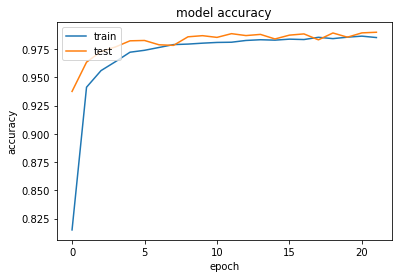

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("spec_250ms_acc.eps")
plt.savefig("spec_250ms_acc.png",dpi=150)
plt.show()


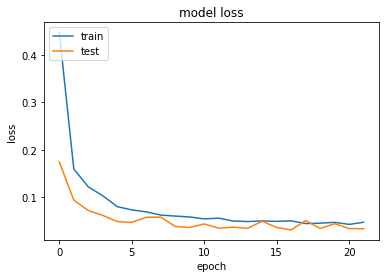

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("spec_250ms_loss.eps")
plt.savefig("spec_250ms_loss.png",dpi=150)
plt.show()


In [9]:
## to get confusion matrix for training_set
#test_generator.reset()
#test_steps = test_generator.n//test_generator.batch_size 

#y = np.ones((len(os.listdir('./500ms/hold_out/' + classes[0] + '/')),1))
#for i in range(1,num_category ):
    #y = np.vstack((y, np.ones((len(os.listdir('./500ms/hold_out/' + classes[i] + '/')),1))))

#y_pred = model.predict_generator(test_generator,
                                        #steps=test_steps,
                                        #verbose=1)
        #y_pred = np.argmax(y_pred, axis=1).astype('int8')
#print(y_pred)
#print(confusion_matrix(y, y_pred))
#print(classification_report(y, y_pred))
#print(accuracy_score(y, y_pred))
#skplt.metrics.plot_confusion_matrix(y, y_pred)
#plt.show()

## Testing

In [10]:
test_generator.reset()
test_steps = test_generator.n//test_generator.batch_size
y_test = model.predict_generator(test_generator,
                                        steps=test_steps,
                                        verbose=1)

1152/1152 [==============================] - 153s 133ms/step


In [11]:
y_test = np.argmax(y_test, axis=1).astype('int8')

In [12]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(true_classes)
print(class_labels)

[0 0 0 ... 3 3 3]
['C', 'FA', 'M', 'S']


In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
report = metrics.classification_report(true_classes, y_test, target_names=class_labels)
print(report)   

             precision    recall  f1-score   support

          C       0.99      0.98      0.99      5760
         FA       1.00      1.00      1.00      5760
          M       0.99      0.99      0.99      5760
          S       0.98      0.99      0.98      5760

avg / total       0.99      0.99      0.99     23040



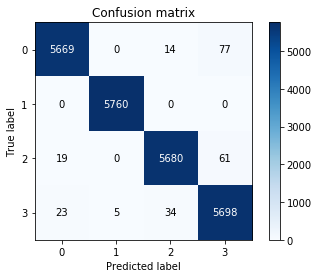

In [14]:
skplt.metrics.plot_confusion_matrix(true_classes, y_test,title='Confusion matrix')
plt.show()

In [15]:
Acc= accuracy_score(true_classes, y_test)
print('Accuracy Score:', Acc)

Accuracy Score: 0.9898871527777777


## Holdout Prediction

In [16]:
hold_generator.reset()
hold_steps = hold_generator.n//hold_generator.batch_size
tic=time.time()
y_holdout = model.predict_generator(hold_generator,
                                        steps=hold_steps,
                                        verbose=1)
tcc=time.time()
print(str(1000*(toc-tic))+"ms")
y_holdout = np.argmax(y_holdout, axis=1).astype('int8')



1152/1152 [==============================] - 289s 251ms/step
-155279.41393852234ms


[0 0 0 ... 3 3 3]
['C', 'FA', 'M', 'S']
             precision    recall  f1-score   support

          C       0.99      0.98      0.99      5760
         FA       1.00      1.00      1.00      5760
          M       0.99      0.98      0.99      5760
          S       0.97      0.99      0.98      5760

avg / total       0.99      0.99      0.99     23040



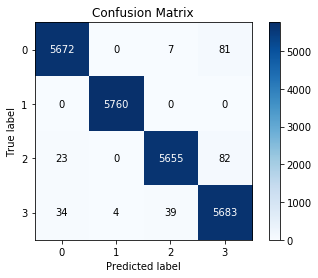

0.9898871527777777


In [17]:
true_classes1 = hold_generator.classes
class_labels1 = list(hold_generator.class_indices.keys())
print(true_classes1)
print(class_labels1)
report1 = metrics.classification_report(true_classes1, y_holdout, target_names=class_labels1)
print(report1)   
skplt.metrics.plot_confusion_matrix(true_classes1, y_holdout )
plt.show()
print(accuracy_score(true_classes, y_test))

### testing using evaluate genrerator

In [18]:
## to get confusion matrix for training_set
test_generator.reset()
test_steps = test_generator.n//test_generator.batch_size 
y = np.ones((len(os.listdir('./250ms/testing_set/' + classes[0] + '/')),1))
for i in range(1,num_category ):
    y = np.vstack((y, np.ones((len(os.listdir('./250ms/testing_set/' + classes[i] + '/')),1))))

test_loss, test_acc = model.evaluate_generator(test_generator,
                                        steps=test_steps,
                                        verbose=1)
print('test acc', test_acc)
print('test loss:', test_loss)

1152/1152 [==============================] - 131s 114ms/step
test acc 0.9898871511945294
test loss: 0.032739201052127825
